<a href="https://colab.research.google.com/github/showmeinfinity/final_project/blob/main/Step_2_calculating_diasgreement_and_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Note that this notebook is run using Google Colab

In [ ]:
!pip install krippendorff
!pip install python-igraph leidenalg
!pip install plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 88.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import krippendorff
from scipy.stats import entropy, stats
import numpy as np
import networkx as nx
import community.community_louvain as community_louvain
import matplotlib.pyplot as plt
import seaborn as sns
import leidenalg
import igraph as ig
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
import random
import plotly.graph_objects as go
import matplotlib.patches as mpatches

In [ ]:
import warnings
warnings.simplefilter("ignore")

In [ ]:
# Set the random seed for reproducibility
np.random.seed(13)
random.seed(13)

Import all datasets

In [ ]:
offensiveness_popquorn = pd.read_csv('offensiveness_popquorn_cleaned.csv')
md_agreement = pd.read_csv('md_agreement_cleaned.csv')

In [ ]:
md_agreement

instance_id                                               text  \
0                1         <user> <user> 30 million unemployed , fool   
1                1         <user> <user> 30 million unemployed , fool   
2                1         <user> <user> 30 million unemployed , fool   
3                1         <user> <user> 30 million unemployed , fool   
4                1         <user> <user> 30 million unemployed , fool   
...            ...                                                ...   
53750        10753  Facts!!!  #Repost miss_pr_piggy ・・・ "Gen Z wil...   
53751        10753  Facts!!!  #Repost miss_pr_piggy ・・・ "Gen Z wil...   
53752        10753  Facts!!!  #Repost miss_pr_piggy ・・・ "Gen Z wil...   
53753        10753  Facts!!!  #Repost miss_pr_piggy ・・・ "Gen Z wil...   
53754        10753  Facts!!!  #Repost miss_pr_piggy ・・・ "Gen Z wil...   

               annotation task  number of annotations lang  hard_label  split  \
0      offensiveness detection                      5   en           0   test   
1      offensiveness detection                      5   en           0   test   
2      offensiveness detection                      5   en           0   test   
3      offensiveness detection                      5   en           0   test   
4      offensiveness detection                      5   en           0   test   
...                        ...                    ...  ...         ...    ...   
53750  offensiveness detection                      5   en           0  train   
53751  offensiveness detection                      5   en           0  train   
53752  offensiveness detection                      5   en           0  train   
53753  offensiveness detection                      5   en           0  train   
53754  offensiveness detection                      5   en           0  train   

       soft_label.0  soft_label.1 other_info.domain  offensiveness  user_id  \
0               0.8           0.2     Elections2020              1      150   
1               0.8           0.2     Elections2020              0      626   
2               0.8           0.2     Elections2020              0       85   
3               0.8           0.2     Elections2020              0      789   
4               0.8           0.2     Elections2020              0      283   
...             ...           ...               ...            ...      ...   
53750           1.0           0.0               BLM              0      117   
53751           1.0           0.0               BLM              0      513   
53752           1.0           0.0               BLM              0      755   
53753           1.0           0.0               BLM              0      455   
53754           1.0           0.0               BLM              0      146   

                                            cleaned_text cleaned_domain  
0                           30 million unemployed , fool  elections2020  
1                           30 million unemployed , fool  elections2020  
2                           30 million unemployed , fool  elections2020  
3                           30 million unemployed , fool  elections2020  
4                           30 million unemployed , fool  elections2020  
...                                                  ...            ...  
53750  facts!!! #repost miss_pr_piggy ・・・ "gen z will...            blm  
53751  facts!!! #repost miss_pr_piggy ・・・ "gen z will...            blm  
53752  facts!!! #repost miss_pr_piggy ・・・ "gen z will...            blm  
53753  facts!!! #repost miss_pr_piggy ・・・ "gen z will...            blm  
53754  facts!!! #repost miss_pr_piggy ・・・ "gen z will...            blm  

[53755 rows x 14 columns]

In [ ]:
offensiveness_popquorn

instance_id  user_id  \
0              530        0   
1              530       43   
2              530       93   
3              530      111   
4              530      125   
...            ...      ...   
13031         1151      109   
13032         1151      121   
13033         1151      166   
13034         1151      213   
13035         1151      234   

                                                    text  offensiveness  \
0      I think a lot of Dethklok songs use drop C, wo...            0.0   
1      I think a lot of Dethklok songs use drop C, wo...            0.0   
2      I think a lot of Dethklok songs use drop C, wo...            0.0   
3      I think a lot of Dethklok songs use drop C, wo...            0.0   
4      I think a lot of Dethklok songs use drop C, wo...            0.0   
...                                                  ...            ...   
13031      Woman's studies is a pretty ridiculous field.            0.0   
13032      Woman's studies is a pretty ridiculous field.            0.0   
13033      Woman's studies is a pretty ridiculous field.            1.0   
13034      Woman's studies is a pretty ridiculous field.            1.0   
13035      Woman's studies is a pretty ridiculous field.            1.0   

      gender             race    age              occupation  \
0        Man            White  35-39              Unemployed   
1        Man            White  35-39                Employed   
2        Man            White  30-34                Employed   
3      Woman            White  40-44                Employed   
4        Man            White  18-24                Employed   
...      ...              ...    ...                     ...   
13031  Woman            Asian  35-39                Employed   
13032  Woman            White  50-54  Prefer not to disclose   
13033  Woman            White  54-59               Homemaker   
13034    Man  Native American  54-59                Employed   
13035    Man            White    >65                 Retired   

                               education  hard_label  soft_label.0  \
0      High school diploma or equivalent           0      0.875000   
1                        Graduate degree           0      0.875000   
2      High school diploma or equivalent           0      0.875000   
3      High school diploma or equivalent           0      0.875000   
4                         College degree           0      0.875000   
...                                  ...         ...           ...   
13031                    Graduate degree           1      0.285714   
13032  High school diploma or equivalent           1      0.285714   
13033  High school diploma or equivalent           1      0.285714   
13034  High school diploma or equivalent           1      0.285714   
13035  High school diploma or equivalent           1      0.285714   

       soft_label.1                                       cleaned_text  
0          0.125000  i think a lot of dethklok songs use drop c, wo...  
1          0.125000  i think a lot of dethklok songs use drop c, wo...  
2          0.125000  i think a lot of dethklok songs use drop c, wo...  
3          0.125000  i think a lot of dethklok songs use drop c, wo...  
4          0.125000  i think a lot of dethklok songs use drop c, wo...  
...             ...                                                ...  
13031      0.714286      woman's studies is a pretty ridiculous field.  
13032      0.714286      woman's studies is a pretty ridiculous field.  
13033      0.714286      woman's studies is a pretty ridiculous field.  
13034      0.714286      woman's studies is a pretty ridiculous field.  
13035      0.714286      woman's studies is a pretty ridiculous field.  

[13036 rows x 13 columns]

# Step 1: Calculating disagreement between raters using Krippendorff's alpha

In [ ]:
# Pivot the datasets to get one row per instance and one column per user
op_pivot_table = offensiveness_popquorn.pivot(index='instance_id', columns='user_id', values='offensiveness')
md_pivot_table = md_agreement.pivot(index='instance_id', columns='user_id', values='offensiveness')

In [ ]:
alpha_md = krippendorff.alpha(reliability_data=md_pivot_table, level_of_measurement='ordinal')
alpha_op = krippendorff.alpha(reliability_data=op_pivot_table, level_of_measurement='ordinal')

An alpha of 0.70 or above is considered acceptable (threshold from papers)

In [ ]:
alpha_md

0.12054946999603322

This value suggests minimal agreement among the raters beyond what would be expected by chance. This indicates a lack of consensus among the raters on the offensiveness scores in the MD dataset.

In [ ]:
alpha_op

0.2047092747463044

This value also suggests a low level of agreement among the raters beyond what would be expected by chance. This indicates a lack of consensus among the raters on the offensiveness scores in the OP dataset as well.

Therefore reviewing instances with high disagreements in ratings and can help understand differences.

The **calculate_agreement_scores** function assesses the level of agreement among annotators using Krippendorff's Alpha which also considers chance agreements. It initialises an agreement matrix based on the number of annotators and calculates pairwise agreement for each pair of annotators. Krippendorff's Alpha function can handle missing values.

In cases where all instances scored by a pair are the same, a perfect agreement (alpha = 1.0) is assigned. If there's a variation in scores, the function calculates Krippendorff's Alpha, handling errors due to lack of variance by assigning a zero agreement.

The function returns a dataframe representing the agreement matrix, with instances having alpha values below 0 highlighting systematic disagreement beyond chance. These instances with the user ratings is then used for further analysism as they indicate a level of disagreement among annotators beyond what would be expected by chance.

In [ ]:
def calculate_agreement_scores(pivoted_data):
    # Initialise a matrix to hold the agreement scores
    agreement_matrix = np.full((pivoted_data.shape[1], pivoted_data.shape[1]), np.nan)

    # Loop over pairs of annotators to calculate pairwise agreement
    for i in range(pivoted_data.shape[1]):
        for j in range(i+1, pivoted_data.shape[1]):

            # Extract the annotations of the i-th and j-th annotator for all instances
            pair_data = pivoted_data.iloc[:, [i, j]]

            # Check whether there are any instances that both annotators have scored
            if not pair_data.dropna().empty:
                if pair_data.nunique().max() <= 1:
                    # If all scored instances are the same, assign perfect agreement
                    alpha = 1.0
                else:
                    try:
                        # Calculate Krippendorff's Alpha considering all instances even if one of the annotators did not provide a score/NA
                        alpha = krippendorff.alpha(pair_data.transpose().values, level_of_measurement='ordinal')
                    except ZeroDivisionError:
                        # Handle cases where Krippendorff's Alpha calculation fails due to lack of variance
                        print(f"Krippendorff's alpha calculation failed for user pair ({i}, {j}). Setting agreement to zero.")
                        alpha = 0.0

                # Store the calculated agreement in the matrix
                agreement_matrix[i, j] = alpha
                agreement_matrix[j, i] = alpha

    # Convert the agreement matrix to a DataFrame for better readability and usability
    agreement_df = pd.DataFrame(agreement_matrix, index=pivoted_data.columns, columns=pivoted_data.columns)

    print("Agreement Scores Calculated\n")
    return agreement_df


In [ ]:
# Calculate agreement scores
md_agreement_df = calculate_agreement_scores(md_pivot_table)
op_agreement_df = calculate_agreement_scores(op_pivot_table)

Agreement Scores Calculated

Agreement Scores Calculated



In [ ]:
md_agreement_df

user_id  0    1    2    3    4    5    6    7    8    9    ...  809  810  811  \
user_id                                                    ...                  
0        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
1        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
2        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
3        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
4        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
...      ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
814      0.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
815      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
816      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
817      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
818      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   

user_id  812   813  814  815  816  817  818  
user_id                                      
0        NaN   NaN  0.0  NaN  NaN  NaN  NaN  
1        NaN   NaN  NaN  NaN  NaN  NaN  NaN  
2        NaN   NaN  NaN  NaN  NaN  NaN  NaN  
3        NaN   NaN  NaN  NaN  NaN  NaN  NaN  
4        NaN   NaN  NaN  NaN  NaN  NaN  NaN  
...      ...   ...  ...  ...  ...  ...  ...  
814      NaN   NaN  NaN  NaN  NaN  NaN  NaN  
815      NaN   NaN  NaN  NaN  NaN  NaN  NaN  
816      NaN   NaN  NaN  NaN  NaN  NaN  NaN  
817      NaN   NaN  NaN  NaN  NaN  NaN  NaN  
818      NaN  0.15  NaN  NaN  NaN  NaN  NaN  

[819 rows x 819 columns]

In [ ]:
op_agreement_df

user_id  0         1    2     3     4    5     6         7     8    9    ...  \
user_id                                                                  ...   
0        NaN       NaN  NaN   NaN   NaN  NaN   NaN       NaN   NaN  NaN  ...   
1        NaN       NaN  NaN   NaN   NaN  NaN   NaN       NaN   NaN  NaN  ...   
2        NaN       NaN  NaN   NaN   NaN  NaN   NaN       NaN   NaN  NaN  ...   
3        NaN       NaN  NaN   NaN   NaN  NaN   NaN       NaN   NaN  NaN  ...   
4        NaN       NaN  NaN   NaN   NaN  NaN   NaN       NaN   NaN  NaN  ...   
...      ...       ...  ...   ...   ...  ...   ...       ...   ...  ...  ...   
257      NaN  1.000000  0.0   NaN   NaN  0.0  0.25  0.571429  0.00  NaN  ...   
258      NaN -0.500000  0.0 -0.25   NaN -0.5   NaN -0.500000 -0.25  NaN  ...   
259      0.0  0.533333  NaN  0.00  0.00 -0.5   NaN  0.000000   NaN  NaN  ...   
261      NaN       NaN  0.0   NaN   NaN  1.0   NaN       NaN   NaN  NaN  ...   
262      NaN       NaN  NaN  0.00 -0.25  1.0   NaN  0.000000 -0.50  0.0  ...   

user_id       252       253       254   255  256  257   258       259  261  \
user_id                                                                      
0             NaN       NaN  0.000000 -0.25  NaN  NaN   NaN  0.000000  NaN   
1        0.000000 -0.666667 -0.500000  0.00  NaN  1.0 -0.50  0.533333  NaN   
2        1.000000 -0.250000  1.000000   NaN  0.0  0.0  0.00       NaN  0.0   
3        0.533333       NaN  0.444444  0.00  0.0  NaN -0.25  0.000000  NaN   
4        0.000000  1.000000  0.000000   NaN  0.0  NaN   NaN  0.000000  NaN   
...           ...       ...       ...   ...  ...  ...   ...       ...  ...   
257           NaN       NaN       NaN   NaN  NaN  NaN   NaN       NaN  NaN   
258           NaN       NaN       NaN   NaN  NaN  NaN   NaN       NaN  NaN   
259           NaN       NaN       NaN   NaN  NaN  NaN   NaN       NaN  NaN   
261           NaN       NaN       NaN   NaN  NaN  NaN   NaN       NaN  NaN   
262           NaN       NaN       NaN   NaN  NaN  NaN   NaN       NaN  NaN   

user_id   262  
user_id        
0         NaN  
1         NaN  
2         NaN  
3        0.00  
4       -0.25  
...       ...  
257       NaN  
258       NaN  
259       NaN  
261       NaN  
262       NaN  

[262 rows x 262 columns]

In [ ]:
md_agreement_df.to_csv("md_agreement_krippendorff.csv", index=False)
op_agreement_df.to_csv("op_agreement_krippendorff.csv", index=False)

# Metrics for Krippendorff's Alpha

- Overall Alpha: Gives a reliability score across all annotators and instances.

- Average Alpha: Reflects the general level of agreement/disagreement among annotator pairs.

- Min/Max Alpha: Highlights the extreme cases of agreement/disagreement levels.

- Percentage of Negative Alphas: Indicates the proportion of pairs with systematic disagreement.

- Distribution of Pairwise Krippendorff's Alpha Scores: Overall patterns in agreement levels.

In [ ]:
def display_krippendorff_metrics(agreement_df, overall_alpha):
    alpha_values = agreement_df.values[np.triu_indices(n=agreement_df.shape[0], k=1)]
    alpha_values = alpha_values[~np.isnan(alpha_values)]

    total_alphas = len(alpha_values)
    negative_alphas = np.sum(alpha_values < 0)

    metrics = {
        "Average Alpha": round(np.mean(alpha_values), 3),
        "Min Alpha": round(np.min(alpha_values), 3),
        "Max Alpha": round(np.max(alpha_values), 3),
        "Percentage of Negative Alphas": f"{round(100 * negative_alphas / total_alphas, 2) if total_alphas > 0 else 0.00}%",
        "Overall Alpha": round(overall_alpha, 3)
    }
    return metrics

In [ ]:
# Calculate metrics
md_metrics = display_krippendorff_metrics(md_agreement_df, alpha_md)
op_metrics = display_krippendorff_metrics(op_agreement_df, alpha_op)

# Create a DataFrame to display the metrics in a tabular format
metrics_df = pd.DataFrame({
    "MD Dataset": md_metrics,
    "OP Dataset": op_metrics
})

print(metrics_df)

                              MD Dataset OP Dataset
Average Alpha                      0.189      0.085
Min Alpha                         -0.889     -0.833
Max Alpha                            1.0        1.0
Percentage of Negative Alphas     19.56%     22.46%
Overall Alpha                      0.121      0.205


In [ ]:
def plot_distribution_of_agreement(agreement_df, file_name):
    # Extracting all non-diagonal elements from the dataframe
    alpha_values = agreement_df.values[np.triu_indices(n=agreement_df.shape[0], k=1)]

    plt.figure(figsize=(10,6))
    sns.histplot(alpha_values, bins=30, kde=True)
    plt.title('Distribution of Pairwise Krippendorff\'s Alpha Scores')
    plt.xlabel('Krippendorff\'s Alpha')
    plt.ylabel('Frequency')
    plt.savefig(file_name, bbox_inches='tight')
    plt.show()

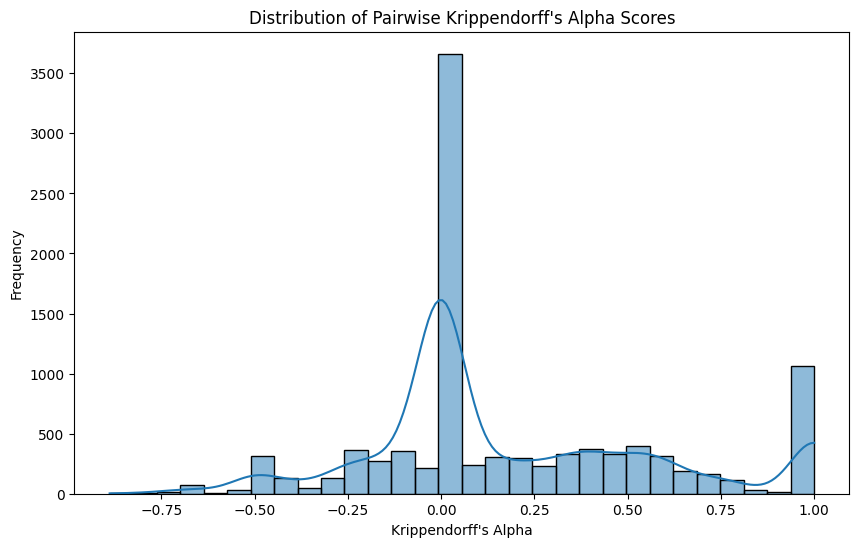

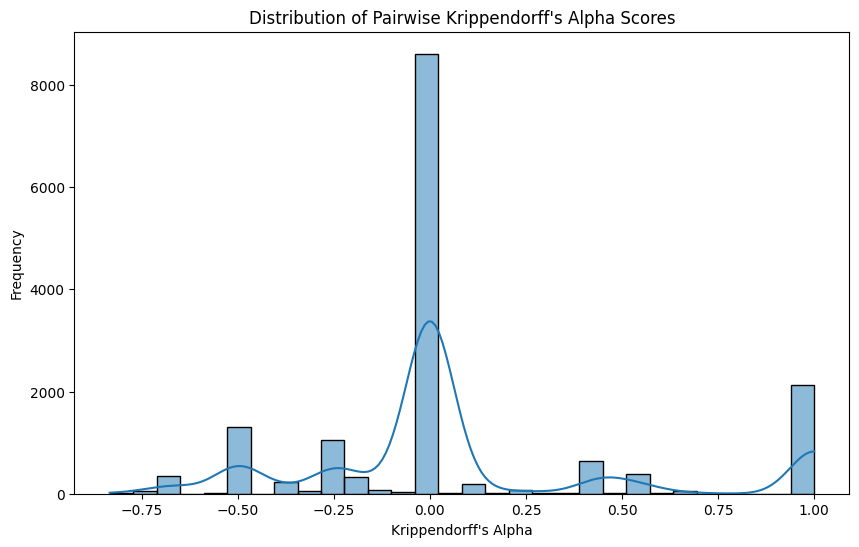

In [ ]:
plot_distribution_of_agreement(md_agreement_df, 'md_agreement_df.png')
plot_distribution_of_agreement(op_agreement_df, 'op_agreement_df.png')

-  Calculate the mean agreement score that each annotator has with every other annotator, based on the pairwise agreement scores

In [ ]:
def individual_rater_reliability(agreement_df):
    reliability_series = agreement_df.mean(axis=1)
    return reliability_series

def plot_individual_reliability(reliability_series):
    plt.figure(figsize=(10, 6))
    reliability_series.sort_values().plot(kind='barh', color='skyblue')
    plt.xlabel('Average Agreement')
    plt.ylabel('Annotator')
    plt.title('Individual Rater Reliability')
    plt.grid(axis='x')
    plt.show()

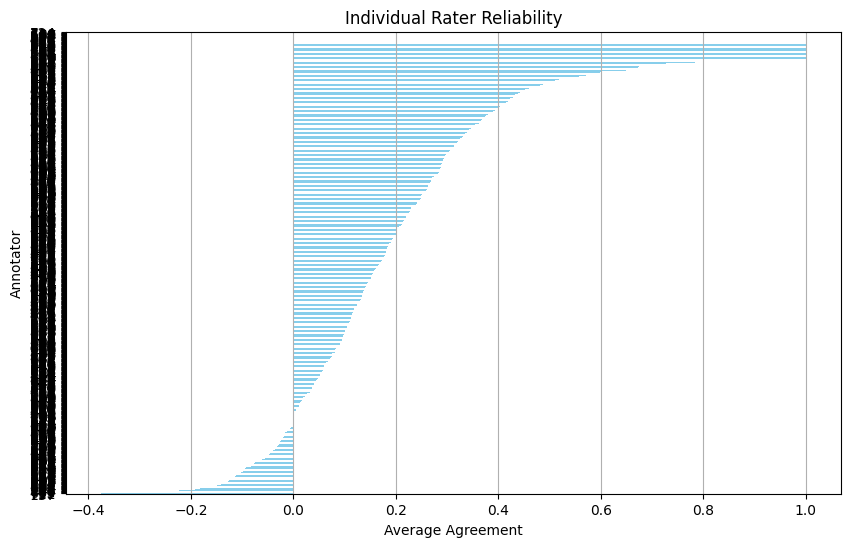

In [ ]:
reliability_series_md = individual_rater_reliability(md_agreement_df)
plot_individual_reliability(reliability_series_md)

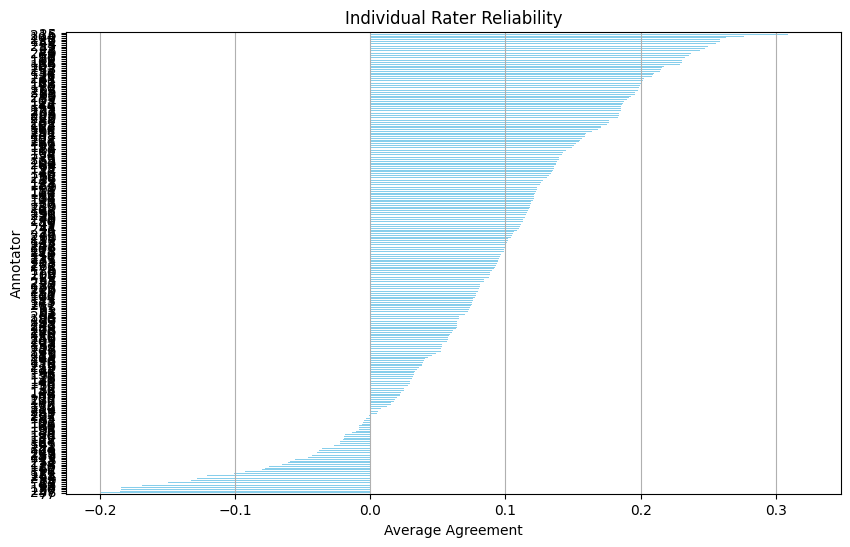

In [ ]:
reliability_series_op = individual_rater_reliability(op_agreement_df)
plot_individual_reliability(reliability_series_op)

- Visualise the agreement matrix showing annotator pairs with high or low agreement.

In [ ]:
def plot_agreement_heatmap(agreement_df):
    plt.figure(figsize=(20, 15))
    sns.heatmap(agreement_df, cmap='coolwarm', center=0)
    plt.title('Annotator Agreement Heatmap', fontsize=20)
    plt.xlabel('Annotator 1', fontsize=15)
    plt.ylabel('Annotator 2', fontsize=15)
    plt.show()

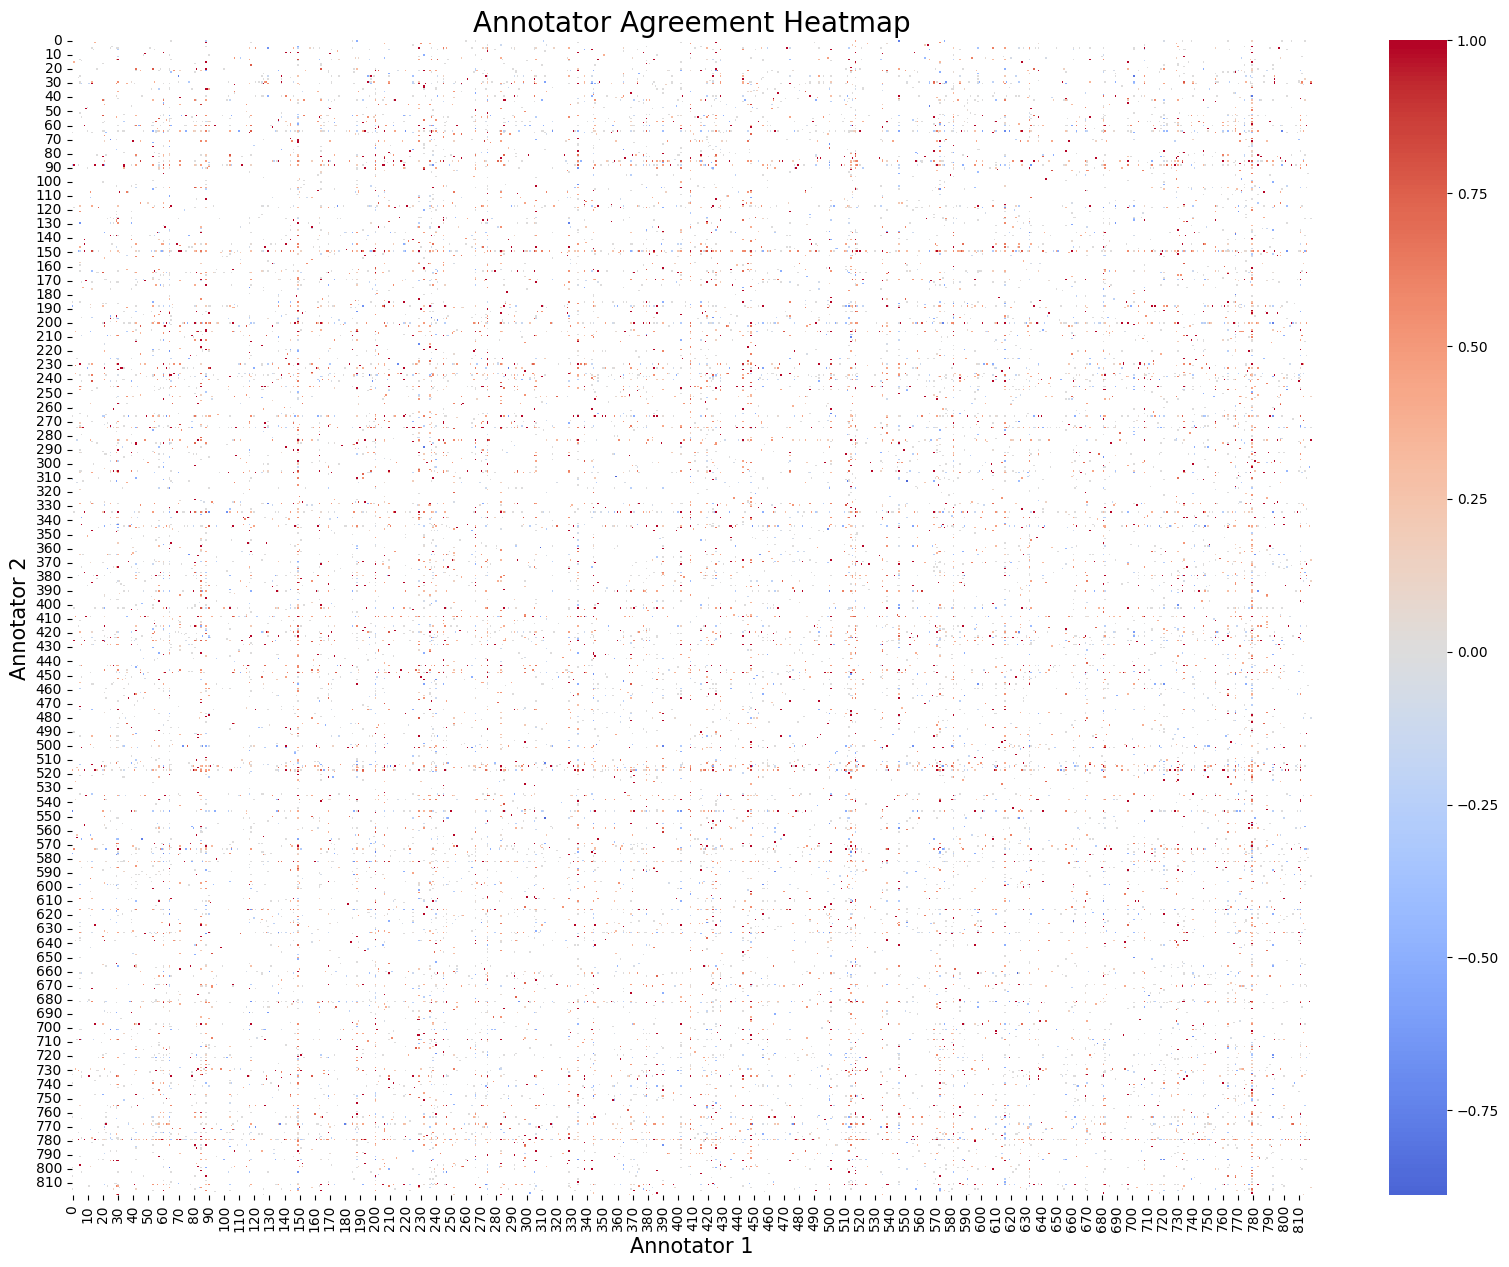

In [ ]:
plot_agreement_heatmap(md_agreement_df)

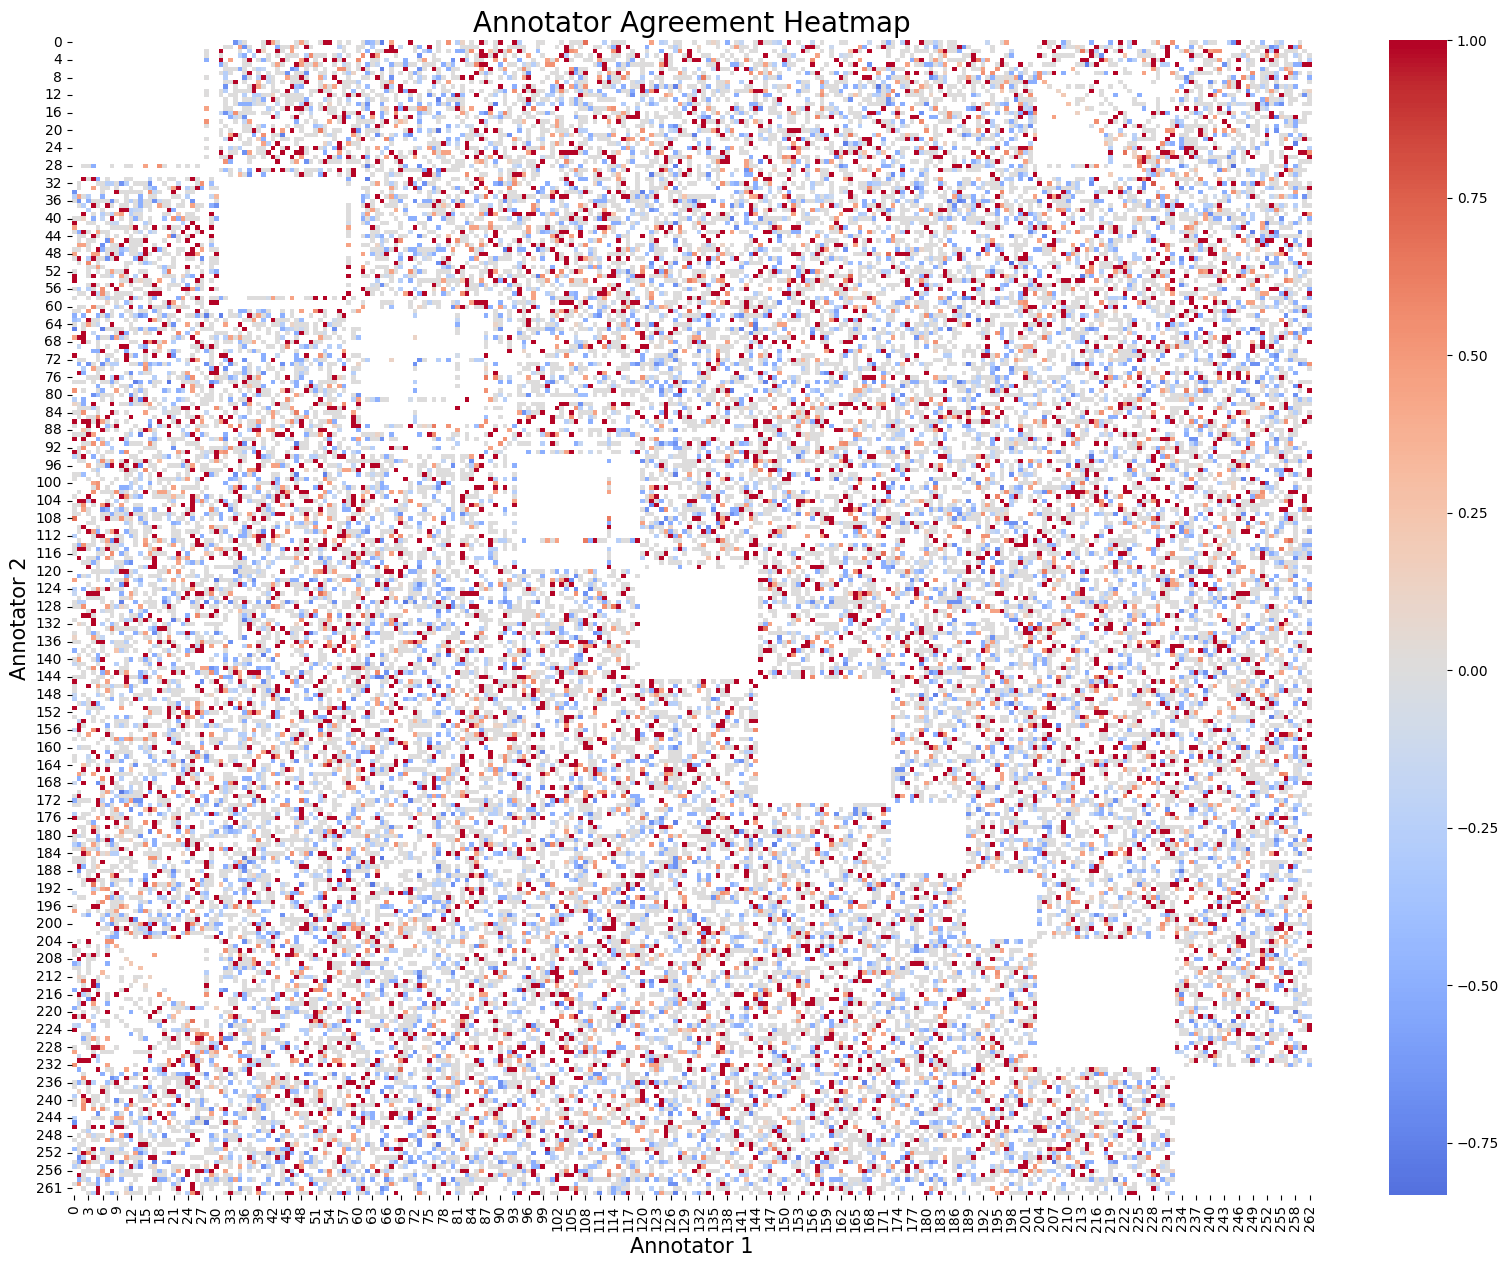

In [ ]:
plot_agreement_heatmap(op_agreement_df)

# Step 2: Building graphs for all datasets

The **visualise_annotator_disagreement** function generates a visual representation of annotator disagreements using a network graph where nodes represent the annotators and edges represent disagreements, defined as negative Krippendorff’s Alpha values. An edge between two nodes (annotators) indicates a pairwise disagreement, and the weight of the edge represents the level of disagreement.

The function can incorporate demographic information, assigning 'race' and 'gender' as node attributes OP dataset. Nodes without any disagreements are excluded to maintain focus on the network of disagreements.

The graph's layout is determined by the Kamada-Kawai algorithm, and node and edge colors are scaled based on the level of total and pairwise disagreement.

In [ ]:
def visualise_annotator_disagreement(agreement_df, demographics_df=None, graph_save_path=None):

    # Create a new graph
    G = nx.Graph()

    # Add edges with weight as disagreement
    for i, user_id1 in enumerate(agreement_df.columns):
        for j, user_id2 in enumerate(agreement_df.columns):
          # only consider lower triangle and negative values
            if j > i and agreement_df.iloc[i, j] < 0:
              # use negative score to get disagreement
                G.add_edge(user_id1, user_id2, weight=-agreement_df.iloc[i, j])

    # If demographic information is provided, add 'race' and 'gender' as node attributes
    if demographics_df is not None:
        for _, row in demographics_df.iterrows():
            user_id = row['user_id']
            if G.has_node(user_id):
                for attr in ['race', 'gender']:
                    if attr in demographics_df.columns:
                        G.nodes[user_id][attr] = row[attr]

    # Remove nodes without any edges (disagreements)
    isolated_nodes = list(nx.isolates(G))
    G.remove_nodes_from(isolated_nodes)

    # Generate layout
    np.random.seed(13)
    layout = nx.kamada_kawai_layout(G)

    # Compute total disagreement per annotator for colour and size mapping
    total_disagreement = pd.Series({user_id: sum(G[user_id][v]['weight'] for v in G[user_id]) for user_id in G.nodes()})

    # Draw the graph
    plt.figure(figsize=(15, 15))

    # Draw nodes
    nodes = nx.draw_networkx_nodes(G, layout, node_color=total_disagreement,
                                   cmap=plt.cm.Oranges, node_size=total_disagreement*200, alpha=0.8)

    # Draw edges
    edge_colors = [G[u][v]['weight'] for u, v in G.edges()]
    edges = nx.draw_networkx_edges(G, layout,
                                   edge_color=edge_colors,
                                   edge_cmap=plt.cm.Blues,
                                   width=[G[u][v]['weight']*2 for u, v in G.edges()])  # scale width for visibility

    plt.title('Filtered Network of Annotator Disagreements', size=15)
    plt.colorbar(nodes, label='Total Disagreement')
    plt.colorbar(edges, label='Pairwise Disagreement', cmap=plt.cm.Blues)
    plt.axis('off')
    plt.show()

    # Save the graph to the specified path as a PNG file
    if graph_save_path:
        plt.savefig(graph_save_path, bbox_inches='tight')

    return G

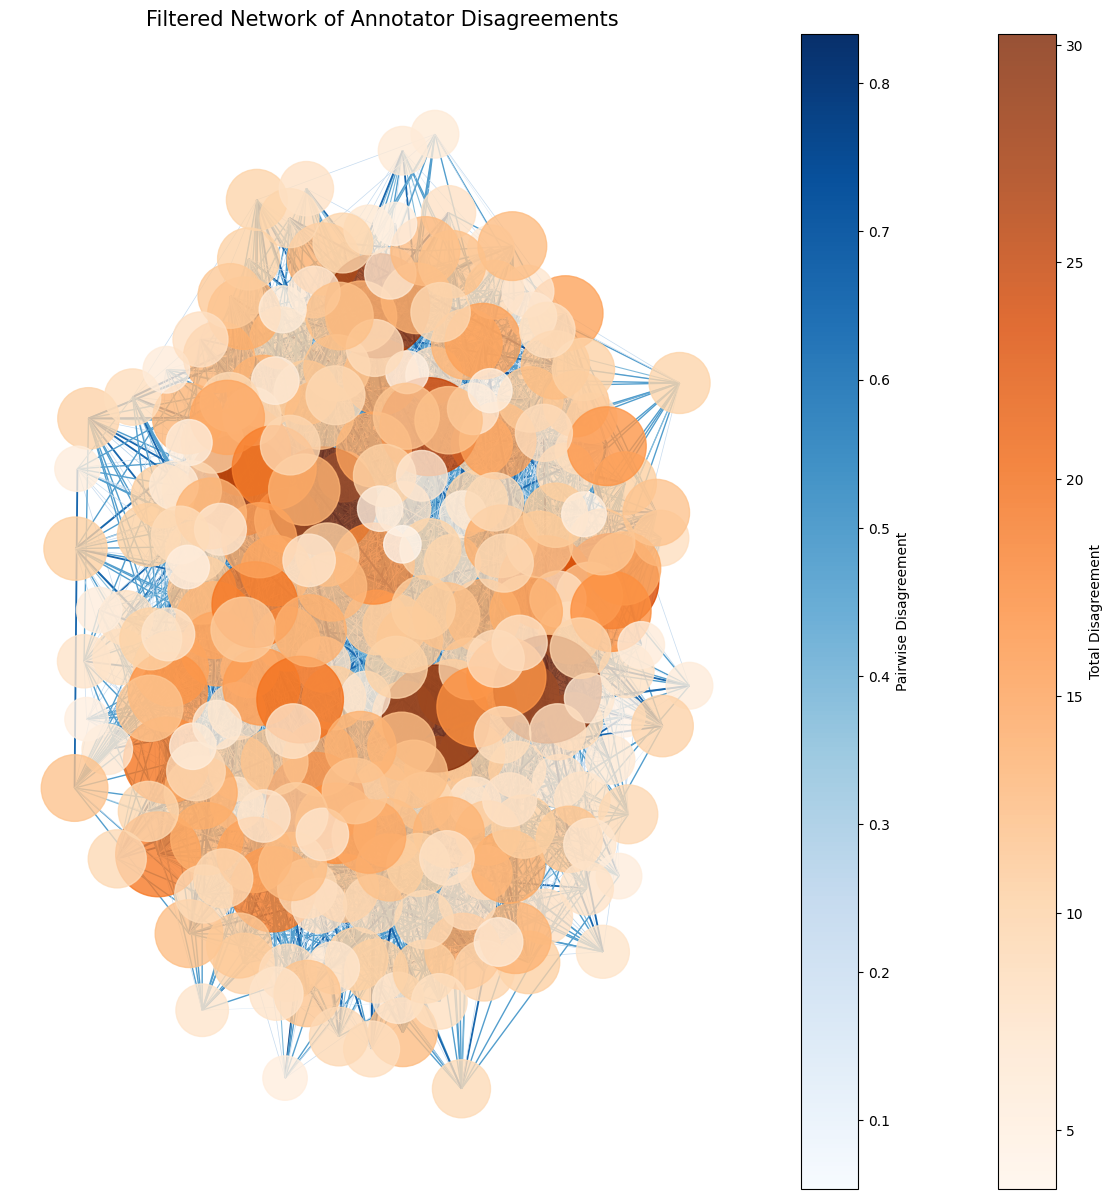

<Figure size 640x480 with 0 Axes>

In [ ]:
# Visualise the graph for the op_agreement_df
G_op = visualise_annotator_disagreement(op_agreement_df, demographics_df=offensiveness_popquorn, graph_save_path='op_annotator_disagreement_graph.png')

In [ ]:
num_nodes = G_op.number_of_nodes()
num_edges = G_op.number_of_edges()

num_nodes, num_edges

(262, 3523)

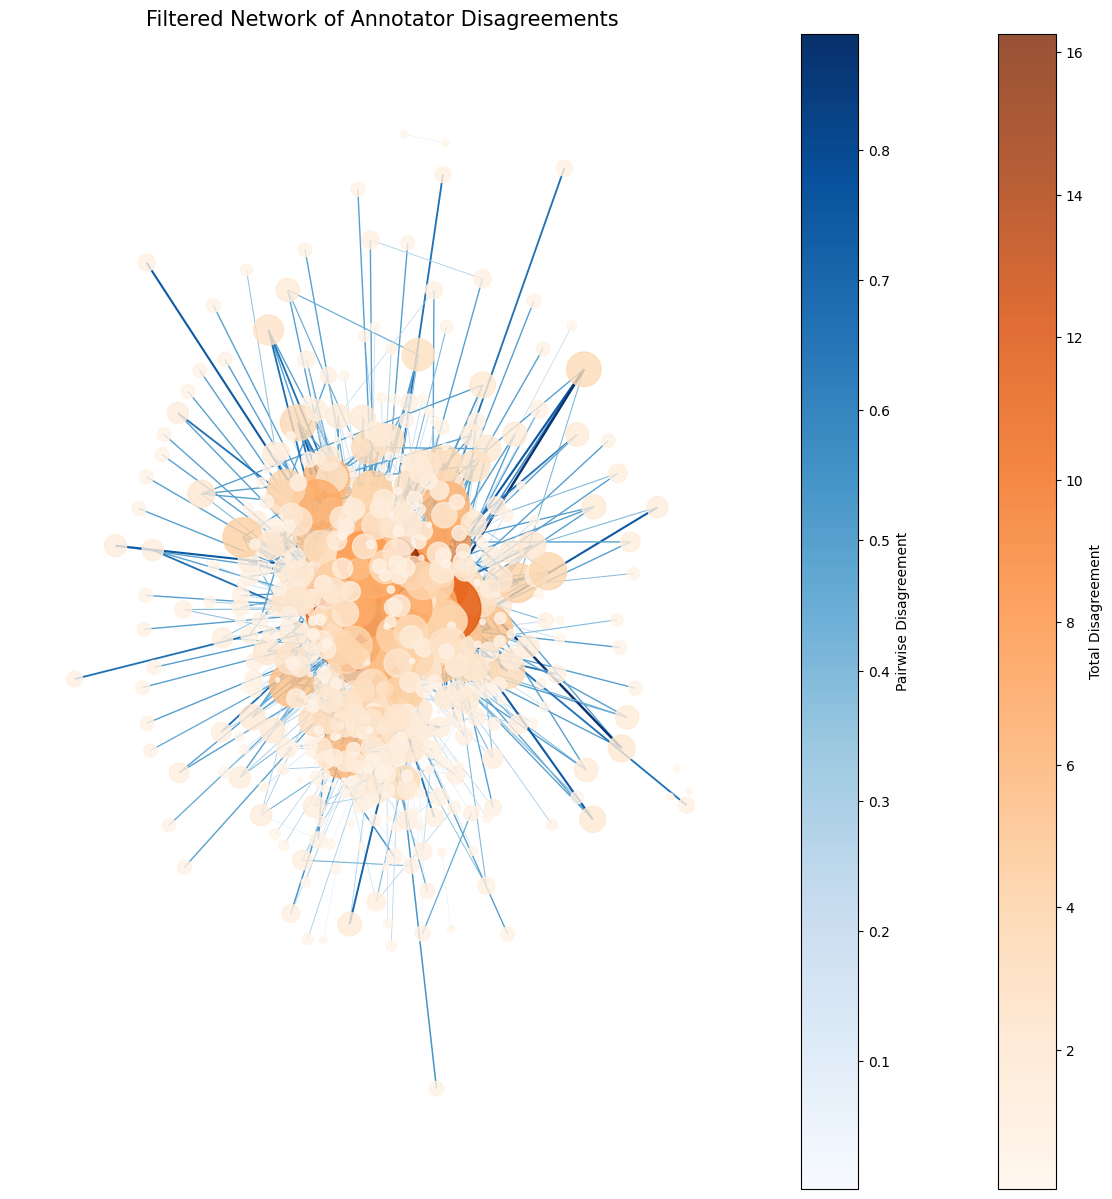

<Figure size 640x480 with 0 Axes>

In [ ]:
G_md = visualise_annotator_disagreement(md_agreement_df, graph_save_path='md_annotator_disagreement_graph.png')

In [ ]:
num_nodes = G_md.number_of_nodes()
num_edges = G_md.number_of_edges()

num_nodes, num_edges

(607, 1959)

# Metrics for Graph

- Node Count: Count of annotators included in the graph

- Edge Count: Number of disagreements present in the graph

- Number of Connected Components: Count of interconnected annotator groups, each linked by disagreements, gives insight into annotator clustering

- Average Degree: Shows the average number of disagreements per annotator

- Graph Density: Represents how interconnected the annotators are

- Average Clustering Coefficient: Provides an average measure of the degree to which nodes in the graph tend to cluster, indicating the tendency for annotators to form tightly knit groups

- Transitivity: Represents the probability that the adjacent vertices of a vertex are connected, showing the overall connectivity within the annotator network

- Assortativity Coefficient: Measures the similarity of connections in the graph with respect to the node degree, indicating whether annotators with a similar number of disagreements tend to connect with each other

- Node Degree Distribution: Visualises the distribution of the number of disagreements each annotator has, offering insight into individual variability in disagreement levels

- Edge Weight Distribution: Visualises the distribution of the levels of disagreement, offering insight into the variability in disagreement intensity

- Clustering Coefficient Distribution: Visualises the degree to which annotators tend to cluster, offering insight into the formation of tightly knit groups in the disagreement network

In [ ]:
def display_graph_metrics(G):
    # Calculate metrics
    metrics = {
        "Node Count": G.number_of_nodes(),
        "Edge Count": G.number_of_edges(),
        "Number of Connected Components": nx.number_connected_components(G),
        "Average Degree": round(np.mean([d for n, d in G.degree()]), 2),
        "Graph Density": round(nx.density(G), 2),
        "Average Clustering Coefficient": round(np.mean(list(nx.clustering(G).values())), 2),
        "Transitivity": round(nx.transitivity(G), 2),
        "Assortativity Coefficient": round(nx.degree_assortativity_coefficient(G), 2)
    }
    return metrics

In [ ]:
md_metrics = display_graph_metrics(G_md)
op_metrics = display_graph_metrics(G_op)

metrics_df = pd.DataFrame({
    "MD Dataset": md_metrics,
    "OP Dataset": op_metrics
})

print(metrics_df)

                                MD Dataset  OP Dataset
Node Count                          607.00      262.00
Edge Count                         1959.00     3523.00
Number of Connected Components        3.00        1.00
Average Degree                        6.45       26.89
Graph Density                         0.01        0.10
Average Clustering Coefficient        0.10        0.10
Transitivity                          0.06        0.10
Assortativity Coefficient            -0.19       -0.16


In [ ]:
def display_graph_visualisation(G):
    # Degree Distribution
    degrees = [degree for node, degree in G.degree()]
    plt.figure(figsize=(10, 6))
    sns.histplot(degrees, kde=False, bins=30)
    plt.title("Node Degree Distribution")
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.show()

    # Visualising Edge Weights
    edge_weights = [data['weight'] for u, v, data in G.edges(data=True)]
    plt.figure(figsize=(10, 6))
    sns.histplot(edge_weights, kde=False, bins=30)
    plt.title('Edge Weight Distribution')
    plt.xlabel('Edge Weight')
    plt.ylabel('Frequency')
    plt.show()

    # Calculating and Visualising Clustering Coefficient
    clustering_coefficients = nx.clustering(G).values()
    plt.figure(figsize=(10, 6))
    sns.histplot(clustering_coefficients, kde=False, bins=30)
    plt.title('Clustering Coefficient Distribution')
    plt.xlabel('Clustering Coefficient')
    plt.ylabel('Frequency')
    plt.show()

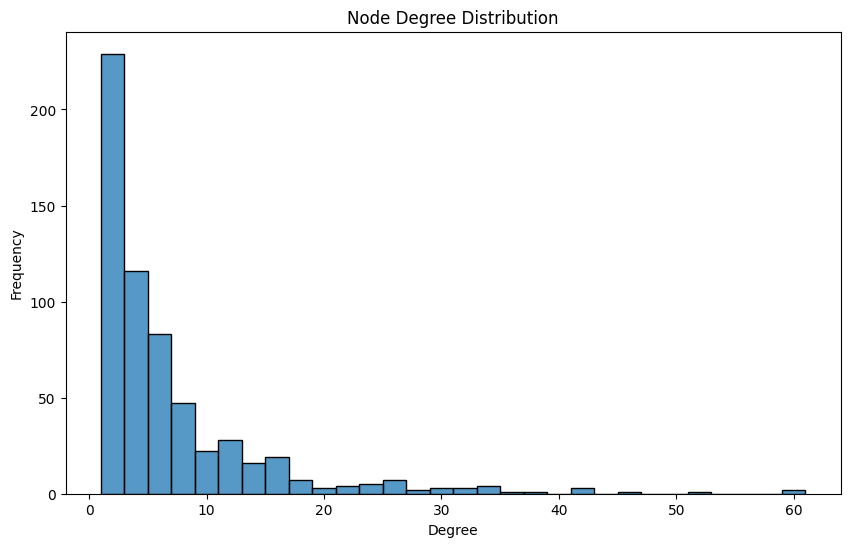

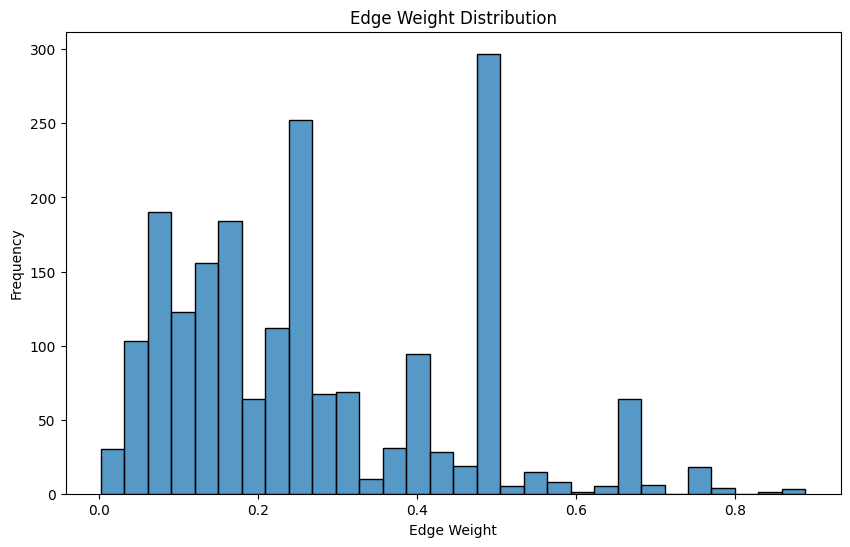

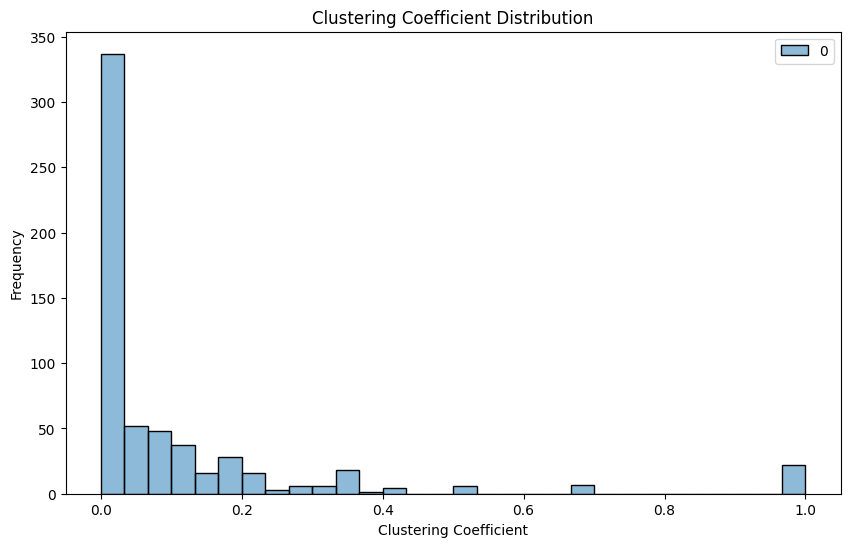

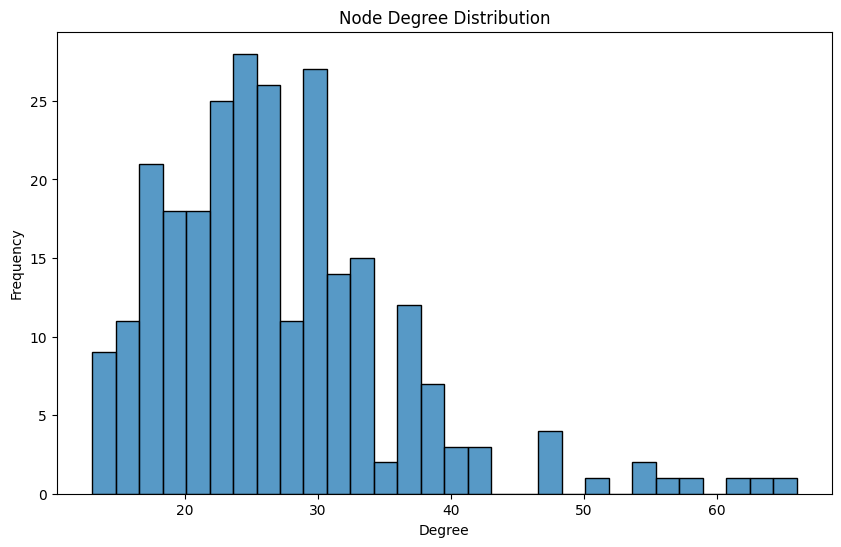

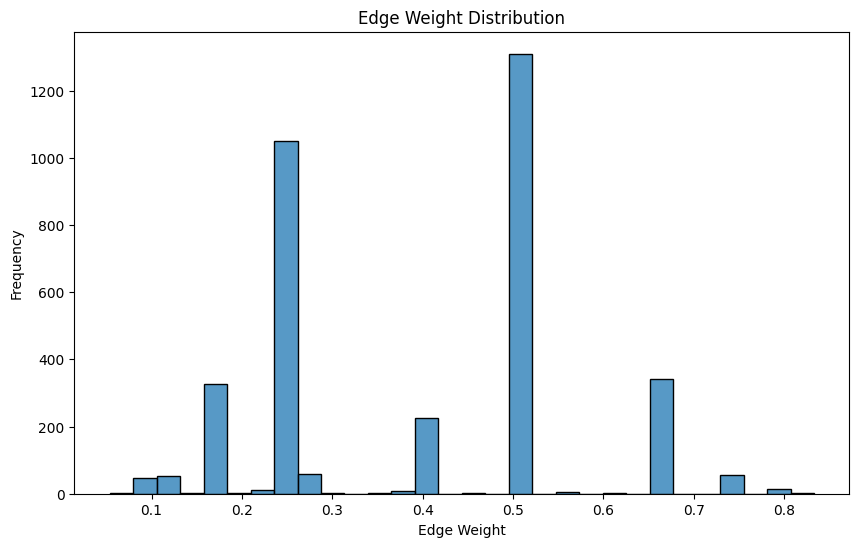

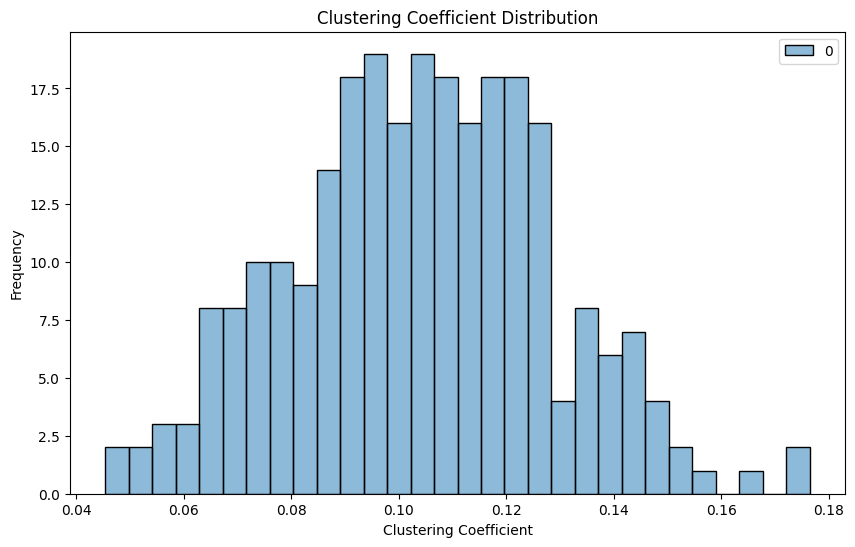

In [ ]:
display_graph_visualisation(G_md)
display_graph_visualisation(G_op)

# Step 3: Community detection algorithms

*Functions for metrics*:

- compute_conductance: This function computes the conductance for each community in the graph, which measures the connectivity of the community to other parts of the graph.

- calculate_and_plot_krippendorffs_alpha: This function recalculates and visualises the Krippendorff's alpha to assess the inter-rater agreement within and between only the annotator communities formed. It creates a heatmap representing average agreements


- calculate_metrics: This function calculates and displays metrics related to the distribution of annotators within the communities

In [ ]:
def compute_conductance(G, partition):

    conductances = {}

    # Invert the partition dictionary to map communities to nodes
    communities = {}
    for node, community in partition.items():
        if community not in communities:
            communities[community] = []
        communities[community].append(node)

    for community, nodes in communities.items():
        # Edges within the community
        internal_edges = G.subgraph(nodes).number_of_edges()

        # Edges leaving the community
        external_edges = sum(1 for node in nodes for neighbor in G.neighbors(node) if neighbor not in nodes)

        # Compute conductance
        conductance = external_edges / (2 * internal_edges + external_edges)
        conductances[community] = conductance

    return conductances

In [ ]:
def calculate_and_plot_krippendorffs_alpha(communities, pivot_table, included_communities=None, output_file=None):
    def calculate_average_alpha(df):
        reliability_data = df.transpose().to_numpy(dtype=float)
        return krippendorff.alpha(reliability_data, level_of_measurement='ordinal')

    # If no specific communities are included, include all available communities.
    if included_communities is None:
        included_communities = list(communities.keys())

    # Extract relevant communities based on included_communities
    relevant_communities = {community: communities[community] for community in included_communities if community in communities}

    # Initialize a DataFrame to store intra and inter-agreement results
    agreement_matrix = pd.DataFrame(index=included_communities, columns=included_communities)

    # Calculate Inter-Rater Agreement within Communities and fill the diagonal of the agreement_matrix
    for community, members in relevant_communities.items():
        subset_df = pivot_table.loc[:, members].dropna(how='all')
        average_agreement = calculate_average_alpha(subset_df)
        agreement_matrix.at[community, community] = average_agreement

    # Calculate Intra-Rater Agreement between Communities and fill the off-diagonal of the agreement_matrix
    for community1, members1 in relevant_communities.items():
        for community2, members2 in relevant_communities.items():
            if community1 != community2:
                subset_df = pivot_table.loc[:, members1 + members2].dropna(how='all')
                average_agreement = calculate_average_alpha(subset_df)
                agreement_matrix.at[community1, community2] = average_agreement

    # Plotting the heatmap
    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(agreement_matrix.astype(float), annot=True, cmap='Blues', fmt=".2f")
    plt.title('Average Agreement Between and Within Communities')
    plt.xlabel('Community')
    plt.ylabel('Community')

    # Invert the Y-axis
    ax.invert_yaxis()

    if output_file:
        plt.savefig(output_file)

    plt.show()


In [ ]:
def calculate_metrics(communities):
    # Calculate the number of annotators in each community
    group_sizes = [len(annotators) for annotators in communities.values()]

    # Calculate the average number of annotators per group
    avg_annotators = np.mean(group_sizes)
    print(f"Average Annotators per Group: {avg_annotators:.2f}")

    # Calculate the standard deviation of annotators per group
    sd_annotators = np.std(group_sizes)
    print(f"Standard Deviation of Annotators per Group: {sd_annotators:.2f}")

    # Plot the distribution of group sizes
    plt.bar(range(len(communities)), group_sizes, tick_label=list(communities.keys()))
    plt.ylabel('Number of Annotators')
    plt.xlabel('Group')
    plt.title('Distribution of Group Sizes')
    plt.show()

## Louvain Algorithm

In [ ]:
def detect_communities_louvain(G, output_file):

    # Compute the best partition using the Louvain method
    partition = community_louvain.best_partition(G)

    plt.figure(figsize=(10, 5))
    pos = nx.spring_layout(G)

    # Ensure each community gets a unique colour
    communities = set(partition.values())
    cmap = plt.cm.get_cmap('jet', len(communities))
    colors = {community: cmap(i) for i, community in enumerate(communities)}

    nx.draw_networkx_nodes(G, pos, node_size=100, node_color=[colors[partition[node]] for node in G.nodes])
    nx.draw_networkx_edges(G, pos, alpha=0.5)

    plt.title('Community Structure (Louvain)')
    plt.axis('off')

    # Create legend handles manually for each community color
    legend_handles = [mpatches.Patch(color=color, label=f'Community {community}') for community, color in colors.items()]

    # Place the legend to the right of the plot
    plt.legend(handles=legend_handles, bbox_to_anchor=(1.05, 0.5), loc='center left')

    # Save the figure before showing it
    plt.savefig(output_file, bbox_inches='tight')
    plt.show()

    return partition

In [ ]:
def print_communities_louvain(partition):

    communities = {}

    # Organize nodes by their respective communities
    for node, community in partition.items():
        communities.setdefault(community, []).append(node)

    # Print the communities
    for community, nodes in communities.items():
        print(f"Community {community}: {nodes}")

    return communities

### MD Agreement full dataset

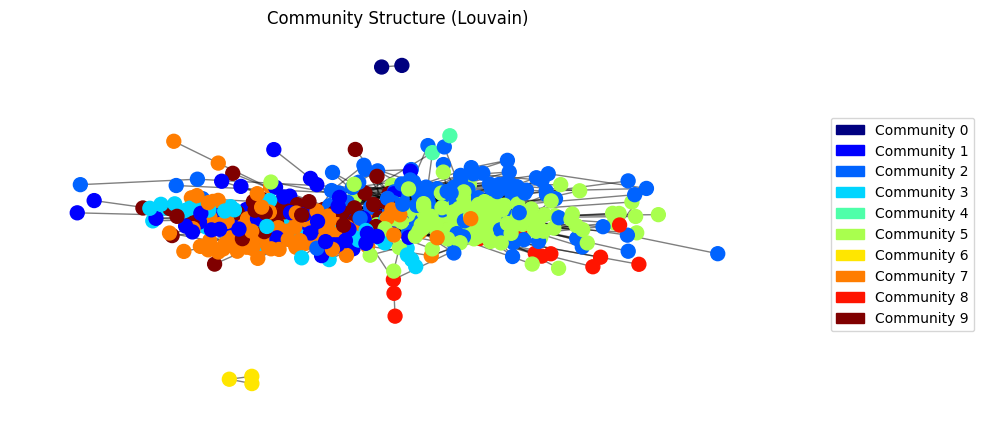

Community 9: [0, 88, 311, 546, 576, 459, 582, 21, 64, 272, 402, 425, 774, 44, 60, 212, 238, 299, 302, 357, 381, 110, 150, 165, 220, 285, 415, 461, 558, 601, 663, 723, 799, 80, 418, 613, 633, 739, 94, 103, 596, 753, 400, 591, 730, 186, 771, 488, 286, 437, 301, 817, 354, 572, 697, 769, 391, 523, 664, 541, 807]
Community 1: [188, 721, 513, 681, 20, 616, 747, 793, 515, 811, 274, 298, 775, 656, 38, 334, 42, 82, 192, 310, 362, 444, 491, 510, 610, 763, 55, 164, 295, 619, 760, 777, 743, 68, 71, 728, 641, 719, 90, 588, 522, 100, 102, 112, 118, 622, 148, 176, 456, 172, 181, 360, 384, 699, 759, 662, 205, 296, 250, 255, 621, 564, 704, 717, 365, 424, 479, 587, 342, 483, 570, 435, 463, 715, 809, 475, 655, 520, 524, 585, 714]
Community 2: [3, 283, 313, 12, 111, 206, 563, 620, 643, 772, 215, 229, 329, 789, 608, 252, 383, 31, 257, 448, 535, 813, 35, 450, 480, 36, 408, 45, 432, 462, 48, 452, 236, 798, 251, 446, 670, 66, 189, 84, 398, 133, 170, 560, 567, 87, 327, 98, 106, 107, 187, 440, 729, 202, 132, 15

In [ ]:
partition_md_louvain = detect_communities_louvain(G_md, 'louvain_communities_md.png')

communities_md_louvain = print_communities_louvain(partition_md_louvain)

modularity_md_louvain = community_louvain.modularity(partition_md_louvain, G_md)
print(f"Modularity (Louvain): {modularity_md_louvain}")

conductances = compute_conductance(G_md, partition_md_louvain)
average_conductance_md_louvain = sum(conductances.values()) / len(conductances)
print(f"Average Conductance (Louvain): {average_conductance_md_louvain}")

Average Annotators per Group: 67.44
Standard Deviation of Annotators per Group: 50.60


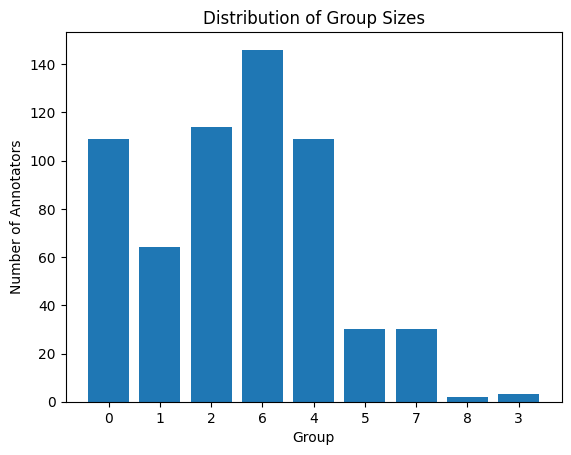

In [ ]:
calculate_metrics(communities_md_louvain)

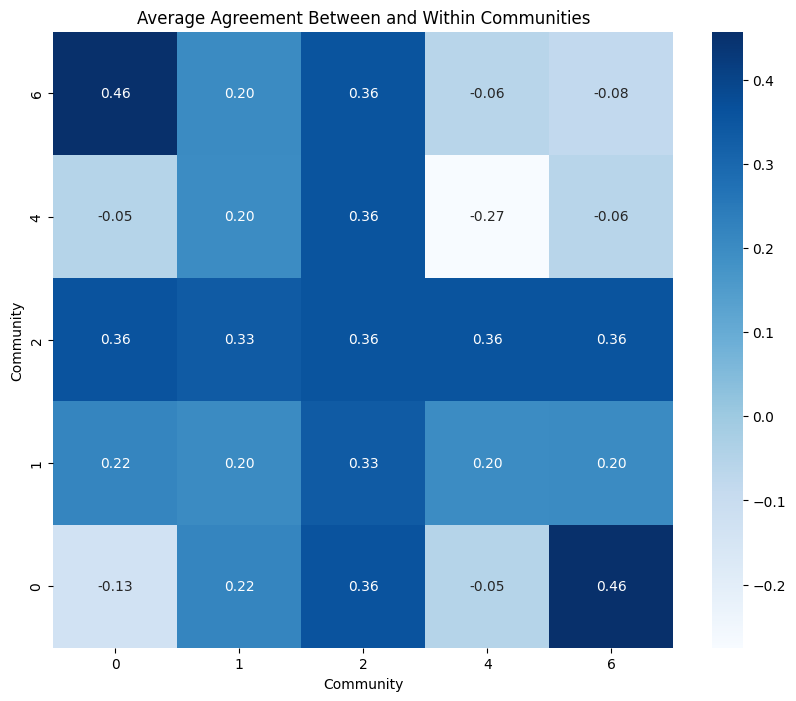

In [ ]:
calculate_and_plot_krippendorffs_alpha(communities_md_louvain, md_pivot_table, included_communities=[0, 1, 2, 4, 6], output_file='krippendorffs_alpha_md_louvain.png')

### Offensiveness Popquorn full dataset

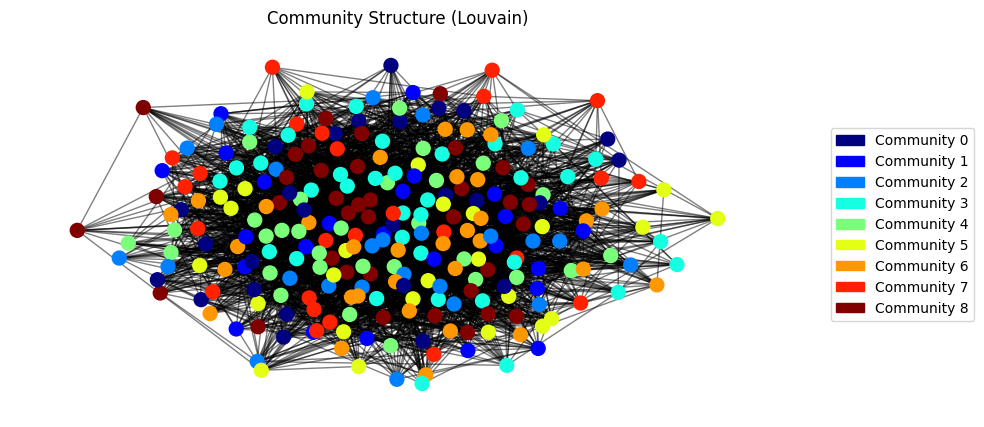

Community 4: [0, 112, 148, 149, 182, 209, 239, 245, 162, 66, 118, 192, 181, 47, 135, 143, 87, 91, 8, 113, 136, 235, 101, 11, 109, 89, 169, 196, 197, 145, 27]
Community 8: [34, 35, 141, 175, 219, 73, 121, 187, 104, 163, 247, 140, 6, 39, 106, 151, 234, 58, 161, 205, 76, 60, 119, 261, 99, 189, 33, 179, 17, 137, 142, 22, 24, 178, 26, 211, 222]
Community 2: [62, 168, 56, 258, 40, 262, 5, 78, 111, 214, 243, 259, 7, 45, 203, 9, 116, 256, 130, 61, 51, 126, 228, 176]
Community 1: [63, 193, 244, 69, 127, 4, 28, 70, 177, 221, 224, 95, 117, 139, 132, 107, 146, 191, 194, 171, 48, 52, 68, 227, 204]
Community 6: [65, 124, 156, 215, 43, 160, 216, 248, 31, 90, 183, 79, 32, 72, 173, 170, 249, 202, 165, 59, 100, 237, 108, 144, 246, 16, 86, 133, 19, 166, 55, 208]
Community 3: [81, 255, 36, 180, 218, 2, 75, 82, 226, 80, 83, 134, 57, 97, 129, 96, 200, 41, 252, 128, 240, 93, 241, 12, 174, 190, 103, 14, 201, 15, 23, 25, 30, 210, 110, 185]
Community 7: [94, 230, 233, 253, 150, 198, 3, 152, 217, 231, 122, 77, 1

In [ ]:
# Detect communities
partition_op_louvain = detect_communities_louvain(G_op, 'louvain_communities_op.png')

communities_op_louvain = print_communities_louvain(partition_op_louvain)

modularity_op_louvain = community_louvain.modularity(partition_op_louvain, G_op)
print(f"Modularity (Louvain): {modularity_op_louvain}")

conductances = compute_conductance(G_op, partition_op_louvain)
average_conductance_op_louvain = sum(conductances.values()) / len(conductances)
print(f"Average Conductance (Louvain): {average_conductance_op_louvain}")

Average Annotators per Group: 29.11
Standard Deviation of Annotators per Group: 4.72


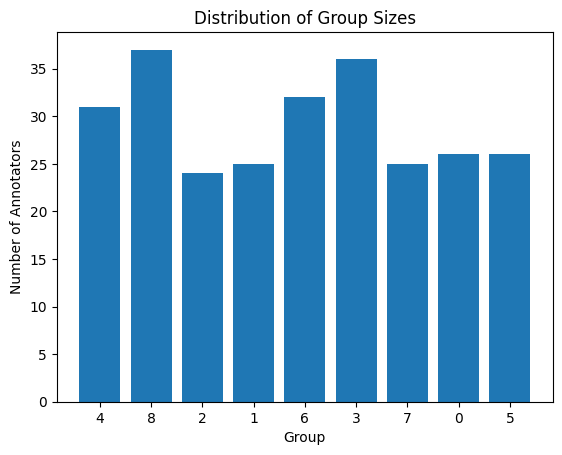

In [ ]:
calculate_metrics(communities_op_louvain)

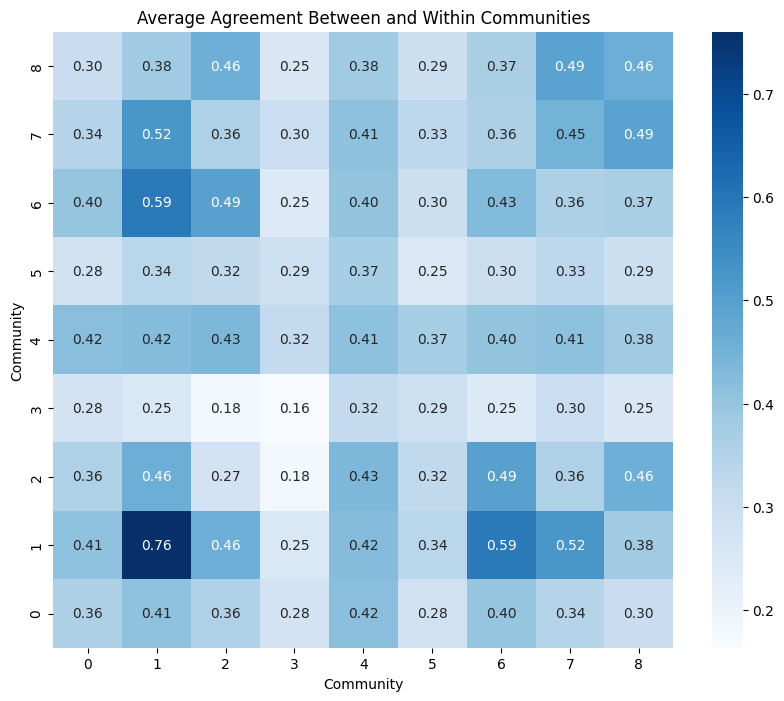

In [ ]:
calculate_and_plot_krippendorffs_alpha(communities_op_louvain, md_pivot_table, included_communities= [0, 1, 2, 3, 4, 5, 6, 7, 8], output_file='krippendorffs_alpha_op_louvain.png')

## Leiden Algorithm

In [ ]:
def detect_communities_leiden(G, output_file):
    ig_graph = ig.Graph.from_networkx(G)
    partition_obj = leidenalg.find_partition(ig_graph, leidenalg.ModularityVertexPartition)

    plt.figure(figsize=(10, 5))
    pos = nx.spring_layout(G)  # Calculate position once

    # Ensure each community gets a unique colour
    communities = set(partition_obj.membership)
    cmap = plt.cm.get_cmap('jet', len(communities))
    colors = {community: cmap(i) for i, community in enumerate(communities)}

    nx.draw_networkx_nodes(G, pos, node_size=100, node_color=[colors[community] for community in partition_obj.membership])
    nx.draw_networkx_edges(G, pos, alpha=0.5)

    plt.title('Community Structure (Leiden)')
    plt.axis('off')

    # Create legend handles manually for each community color
    legend_handles = [mpatches.Patch(color=color, label=f'Community {community}') for community, color in colors.items()]

    # Place the legend to the right of the plot
    plt.legend(handles=legend_handles, bbox_to_anchor=(1.05, 0.5), loc='center left')

    # Save the figure before showing it
    plt.savefig(output_file, bbox_inches='tight')
    plt.show()

    nodes_order = list(G.nodes())
    partition_dict = {nodes_order[node]: membership for node, membership in enumerate(partition_obj.membership)}

    return partition_dict, ig_graph, partition_obj


In [ ]:
def print_communities_leiden(partition):

    # Create an empty dictionary for communities
    communities = {}

    # Loop through each node and their assigned community in the partition
    for node, community in partition.items():
        # If the community is not in the dictionary, add it with the node
        if community not in communities:
            communities[community] = [node]
        # If the community is already in the dictionary, append the node to it
        else:
            communities[community].append(node)

    # Print out the communities
    for community, nodes in communities.items():
        print(f"Community {community}: {nodes}")

    return communities

### MD Agreement full dataset

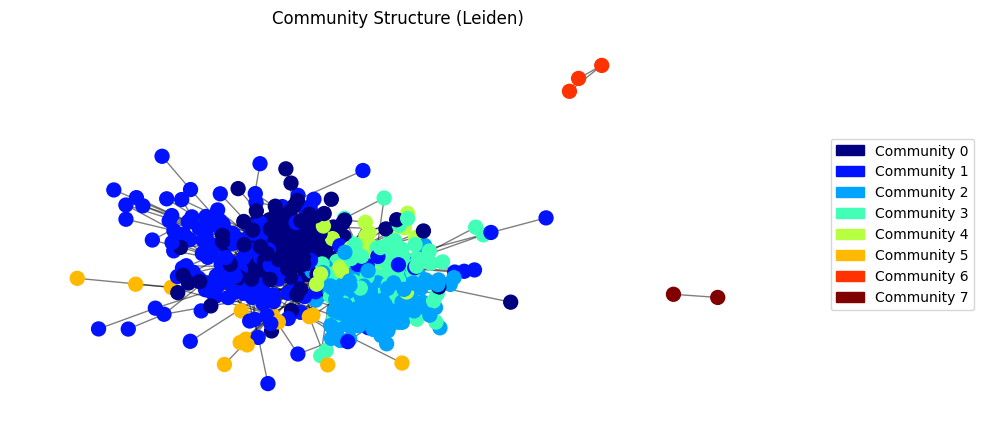

Community 3: [0, 88, 188, 311, 546, 576, 721, 20, 266, 616, 747, 793, 21, 64, 272, 402, 425, 515, 811, 573, 345, 656, 41, 334, 42, 82, 104, 169, 192, 310, 362, 371, 377, 491, 510, 610, 774, 784, 44, 60, 53, 72, 105, 276, 417, 430, 763, 55, 58, 173, 212, 238, 379, 381, 62, 164, 75, 134, 144, 165, 220, 285, 415, 420, 461, 601, 723, 760, 777, 799, 81, 641, 719, 713, 418, 588, 613, 633, 739, 94, 100, 102, 332, 389, 596, 753, 112, 118, 518, 400, 151, 591, 730, 748, 186, 360, 384, 699, 759, 662, 205, 488, 250, 635, 782, 286, 354, 424, 479, 572, 587, 697, 342, 657, 483, 570, 769, 815, 391, 523, 520, 524, 541, 585, 807]
Community 1: [3, 283, 313, 12, 111, 206, 563, 620, 643, 772, 215, 229, 329, 688, 789, 252, 383, 31, 257, 448, 535, 813, 35, 450, 480, 36, 408, 45, 432, 462, 48, 452, 236, 299, 798, 110, 150, 251, 446, 538, 670, 66, 189, 71, 728, 84, 398, 85, 133, 170, 326, 336, 560, 567, 87, 327, 98, 106, 107, 187, 440, 729, 202, 132, 155, 114, 122, 603, 707, 228, 281, 749, 158, 626, 786, 370, 

In [ ]:
# Detect communities
partition_md_leiden, ig_graph_md_leiden, partition_obj_md_leiden = detect_communities_leiden(G_md, output_file='leiden_communities_md')

communities_md_leiden = print_communities_leiden(partition_md_leiden)

# Calculate modularity using leidenalg's quality method
modularity_md_leiden = partition_obj_md_leiden.quality()
print(f"Modularity (Leiden): {modularity_md_leiden}")

conductances = compute_conductance(G_md, partition_md_leiden)
average_conductance_md_leiden = sum(conductances.values()) / len(conductances)
print(f"Average Conductance (Leiden): {average_conductance_md_leiden}")

Average Annotators per Group: 75.88
Standard Deviation of Annotators per Group: 65.89


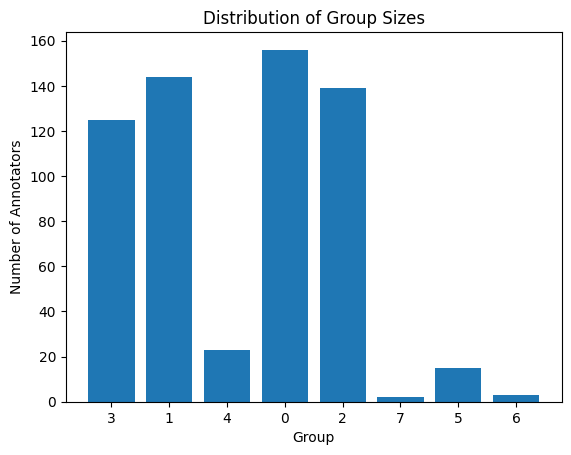

In [ ]:
calculate_metrics(communities_md_leiden)

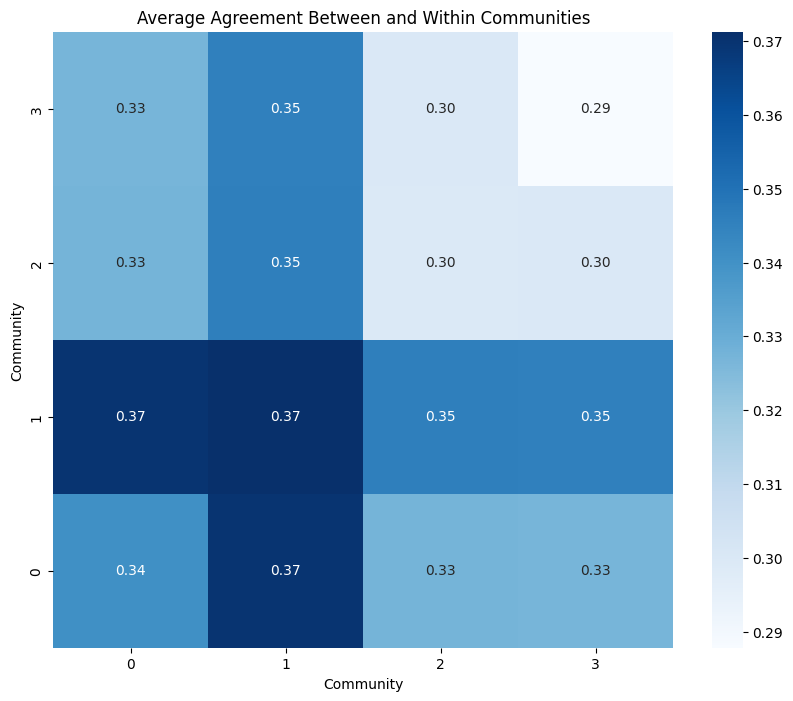

In [ ]:
calculate_and_plot_krippendorffs_alpha(communities_md_leiden, md_pivot_table, included_communities= [0, 1, 2, 3], output_file='krippendorffs_alpha_md_leiden.png')

### Offensiveness Popquorn full dataset

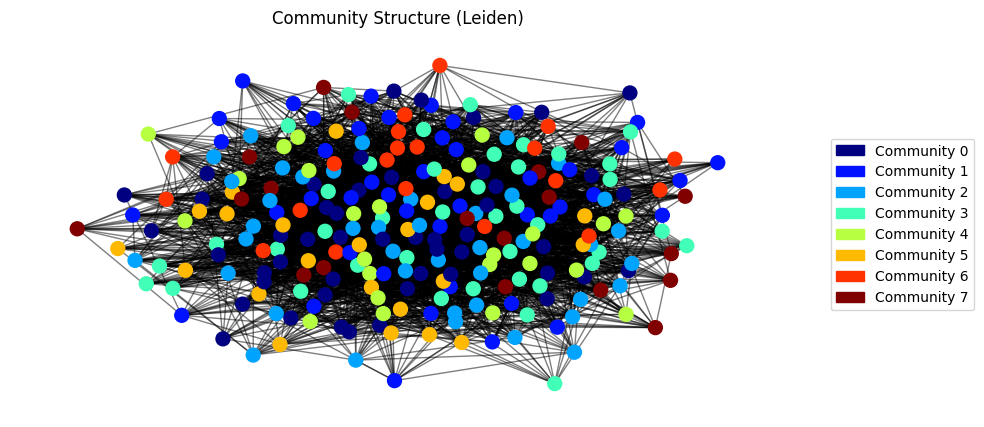

Community 6: [0, 34, 141, 175, 193, 209, 219, 244, 163, 7, 45, 161, 205, 76, 60, 169, 99, 26, 227, 185]
Community 3: [35, 94, 124, 215, 154, 160, 258, 187, 49, 162, 4, 40, 83, 177, 248, 78, 111, 47, 199, 72, 91, 116, 123, 11, 109, 241, 220, 130, 201, 61, 19, 51, 84, 126, 85, 22, 250, 211, 228, 176]
Community 0: [62, 148, 168, 172, 182, 239, 251, 255, 73, 230, 254, 66, 134, 221, 5, 31, 67, 181, 214, 243, 259, 6, 46, 106, 143, 234, 58, 87, 122, 200, 159, 10, 158, 256, 147, 261, 13, 164, 196, 50, 189, 179, 17, 137, 18, 44, 30, 110, 213, 207]
Community 2: [63, 65, 81, 156, 114, 180, 218, 38, 80, 262, 57, 90, 79, 129, 96, 173, 170, 191, 249, 48, 93, 101, 165, 59, 131, 12, 100, 225, 237, 14, 108, 144, 246, 186, 142, 257, 232, 29, 208, 210, 206]
Community 1: [112, 149, 245, 1, 36, 121, 127, 167, 188, 233, 2, 37, 98, 150, 198, 216, 226, 3, 104, 152, 217, 28, 70, 192, 95, 97, 231, 135, 155, 136, 235, 240, 89, 174, 190, 33, 86, 68, 88, 25, 229, 27, 212, 105, 222]
Community 7: [125, 43, 236, 253,

In [ ]:
# Detect communities
partition_op_leiden, ig_graph_op_leiden, partition_obj_op = detect_communities_leiden(G_op, output_file='leiden_communities_op')

communities_op_leiden = print_communities_leiden(partition_op_leiden)

# Calculate modularity using leidenalg's quality method
modularity_op_leiden = partition_obj_op.quality()
print(f"Modularity (Leiden): {modularity_op_leiden}")

conductances = compute_conductance(G_op, partition_op_leiden)
average_conductance_op_leiden = sum(conductances.values()) / len(conductances)
print(f"Average Conductance (Leiden): {average_conductance_op_leiden}")

Average Annotators per Group: 32.75
Standard Deviation of Annotators per Group: 11.68


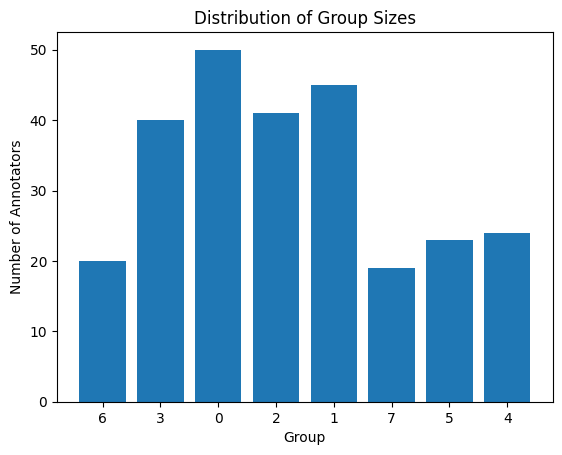

In [ ]:
calculate_metrics(communities_op_leiden)

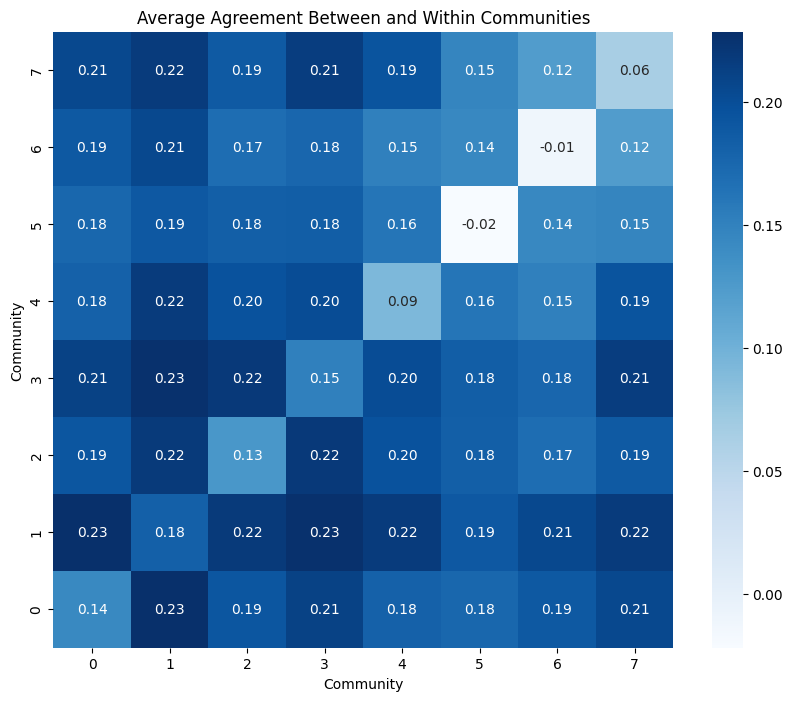

In [ ]:
calculate_and_plot_krippendorffs_alpha(communities_op_leiden, op_pivot_table, included_communities= [0, 1, 2, 3, 4, 5, 6, 7], output_file='krippendorffs_alpha_op_leiden.png')

## Spectral Clustering

In [ ]:
def detect_communities_and_compute_modularity(G, n_clusters):

    # Get the adjacency matrix
    adjacency_matrix = nx.adjacency_matrix(G).toarray()

    # Perform spectral clustering
    sc = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', n_init=100, random_state=32)
    labels = sc.fit_predict(adjacency_matrix)

    # Create a dictionary that maps each node to its community label
    partition_dict = dict(zip(list(G.nodes()), labels))

    m = len(G.edges())
    a = {}
    e = {}

    # Compute the fraction of edges that fall inside each community
    for node, community in partition_dict.items():
        e[community] = e.get(community, 0) + sum(1 for neighbor in G.neighbors(node) if partition_dict[neighbor] == community)

    # Compute the fraction of edges that connect to each community
    for node, community in partition_dict.items():
        k = G.degree(node)
        a[community] = a.get(community, 0) + k

    # Modularity computation
    modularity = sum((e[community] / (2 * m)) - (a[community] / (2 * m)) ** 2 for community in set(partition_dict.values()))

    return modularity

def compute_modularity_multiple_k(G, k_range):

    return {k: detect_communities_and_compute_modularity(G, k) for k in k_range}

In [ ]:
# Compute modularity for cluster numbers ranging from 2 to 10
k_range = range(2, 10)

modularity_values_md = compute_modularity_multiple_k(G_md, k_range)
modularity_values_op = compute_modularity_multiple_k(G_op, k_range)

print("G_md Modularity Values:", modularity_values_md)
print("G_op Modularity Values:", modularity_values_op)

G_md Modularity Values: {2: 0.0030580968037729533, 3: 0.00407694125697261, 4: 0.006107855238619423, 5: 0.18909192817224774, 6: 0.41000411446391716, 7: 0.4110223074820445, 8: 0.41278769652818975, 9: 0.4132215522863938}
G_op Modularity Values: {2: 0.10048346984485154, 3: 0.11599050366800093, 4: 0.12368472087524426, 5: 0.12810794705471018, 6: 0.12786124094783163, 7: 0.12363855412173633, 8: 0.12289690496634219, 9: 0.12052108970619173}


n_cluster for each:
- G_md: 6 - biggest change in modularity chosen (tried highest but the extras are more outliers)
- G_op: 5 (highest modularity)

In [ ]:
def detect_communities_spectral(G, n_clusters):

    # Get the adjacency matrix
    adjacency_matrix = nx.adjacency_matrix(G).toarray()

    # Perform spectral clustering
    sc = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', n_init=100, random_state=13)
    labels = sc.fit_predict(adjacency_matrix)

    # Create a dictionary that maps each node to its community label
    partition_dict = dict(zip(list(G.nodes()), labels))

    # Create a figure of size 8x8 inches
    plt.figure(figsize=(8, 8))

    # Create a dictionary that maps community numbers to different colours
    colors = {community: color for community, color in enumerate(set(partition_dict.values()))}

    # Draw the nodes, with node colour indicating community
    nx.draw_networkx_nodes(G, pos=nx.spring_layout(G), node_size=100, cmap=plt.cm.jet, node_color=[colors[partition_dict[node]] for node in G.nodes()])

    # Draw the edges
    nx.draw_networkx_edges(G, pos=nx.spring_layout(G), alpha=0.5)

    # Show the plot
    plt.show()

    return partition_dict

In [ ]:
def detect_communities_spectral(G, n_clusters, output_file):

    # Get the adjacency matrix
    adjacency_matrix = nx.adjacency_matrix(G).toarray()

    # Perform spectral clustering
    sc = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', n_init=100, random_state=13)
    labels = sc.fit_predict(adjacency_matrix)

    # Create a dictionary that maps each node to its community label
    partition_dict = dict(zip(list(G.nodes()), labels))

    # Create a figure of size 10x5 inches
    plt.figure(figsize=(10, 5))

    # Position the nodes using spring layout
    pos = nx.spring_layout(G)

    # Ensure each community gets a unique colour
    communities = set(partition_dict.values())
    cmap = plt.cm.get_cmap('jet', len(communities))
    colors = {community: cmap(i) for i, community in enumerate(communities)}

    # Draw the nodes, with node colour indicating community
    nx.draw_networkx_nodes(G, pos, node_size=100, node_color=[colors[partition_dict[node]] for node in G.nodes()])

    # Draw the edges
    nx.draw_networkx_edges(G, pos, alpha=0.5)

    plt.title('Community Structure (Spectral)')
    plt.axis('off')

    # Create legend handles manually for each community color
    legend_handles = [mpatches.Patch(color=color, label=f'Community {community}') for community, color in colors.items()]

    # Place the legend to the right of the plot
    plt.legend(handles=legend_handles, bbox_to_anchor=(1.05, 0.5), loc='center left')

    # Save the figure before showing it
    plt.savefig(output_file, bbox_inches='tight')
    plt.show()

    return partition_dict


In [ ]:
def print_communities_spectral(partition):

    # Create an empty dictionary for communities
    communities = {}

    # Loop through each node and their assigned community in the partition
    for node, community in partition.items():
        # If the community is not in the dictionary, add it with the node
        if community not in communities:
            communities[community] = [node]
        # If the community is already in the dictionary, append the node to it
        else:
            communities[community].append(node)

    # Print out the communities
    for community, nodes in communities.items():
        print(f"Community {community}: {nodes}")

    return communities

In [ ]:
def compute_modularity_spectral(G, partition):

    m = len(G.edges())
    a = {}
    e = {}

    # Compute the fraction of edges that fall inside each community
    for node, community in partition.items():
        e[community] = e.get(community, 0) + sum(1 for neighbor in G.neighbors(node) if partition[neighbor] == community)

    # Compute the fraction of edges that connect to each community
    for node, community in partition.items():
        k = G.degree(node)
        a[community] = a.get(community, 0) + k

    # Modularity computation
    modularity = sum((e[community] / (2 * m)) - (a[community] / (2 * m)) ** 2 for community in set(partition.values()))

    return modularity

### MD Agreement full dataset

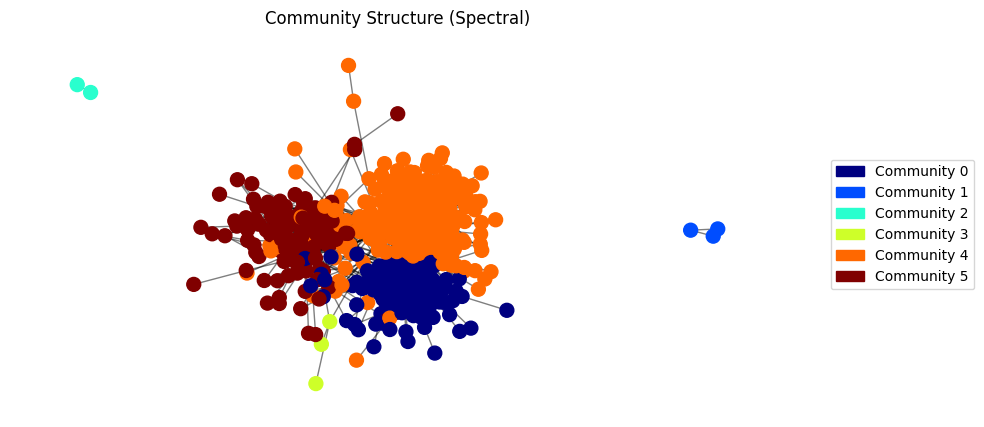

Community 4: [0, 88, 188, 311, 546, 576, 721, 4, 149, 459, 632, 10, 232, 681, 423, 582, 20, 266, 517, 616, 747, 793, 21, 64, 136, 215, 229, 272, 344, 402, 425, 515, 688, 811, 22, 65, 573, 274, 26, 779, 656, 33, 288, 34, 57, 500, 718, 751, 152, 37, 669, 768, 38, 41, 334, 42, 82, 104, 169, 192, 310, 362, 371, 377, 444, 491, 510, 610, 774, 784, 44, 60, 47, 390, 438, 449, 750, 51, 52, 53, 72, 105, 185, 219, 223, 276, 417, 430, 763, 55, 56, 555, 273, 317, 434, 58, 173, 59, 200, 212, 236, 238, 293, 302, 357, 379, 381, 514, 660, 62, 164, 240, 75, 110, 134, 144, 150, 165, 220, 251, 285, 295, 369, 415, 420, 461, 477, 538, 558, 601, 619, 663, 670, 723, 733, 741, 760, 777, 799, 743, 68, 71, 728, 73, 74, 120, 76, 79, 557, 80, 81, 641, 648, 719, 85, 326, 336, 453, 713, 783, 86, 90, 422, 249, 418, 588, 613, 633, 739, 522, 589, 92, 254, 94, 95, 99, 100, 102, 103, 332, 389, 596, 753, 109, 112, 115, 118, 518, 622, 135, 180, 210, 464, 675, 137, 400, 147, 504, 505, 148, 176, 370, 376, 396, 456, 651, 722,

In [ ]:
# Detect communities using spectral clustering
partition_md_spectral = detect_communities_spectral(G_md,6, 'spectral_communities_md.png')

communities_md_spectral = print_communities_spectral(partition_md_spectral)

modularity_md_spectral = compute_modularity_spectral(G_md, partition_md_spectral)
print(f"Modularity (Spectral): {modularity_md_spectral}")

conductances = compute_conductance(G_md, partition_md_spectral)
average_conductance_md_spectral = sum(conductances.values()) / len(conductances)
print(f"Average Conductance (Spectral): {average_conductance_md_spectral}")

Average Annotators per Group: 101.17
Standard Deviation of Annotators per Group: 118.79


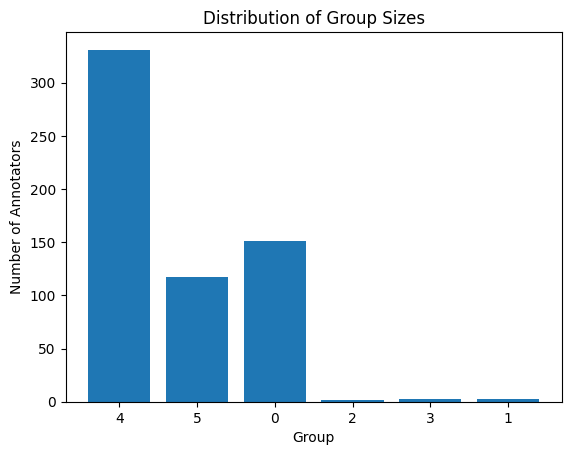

In [ ]:
calculate_metrics(communities_md_spectral)

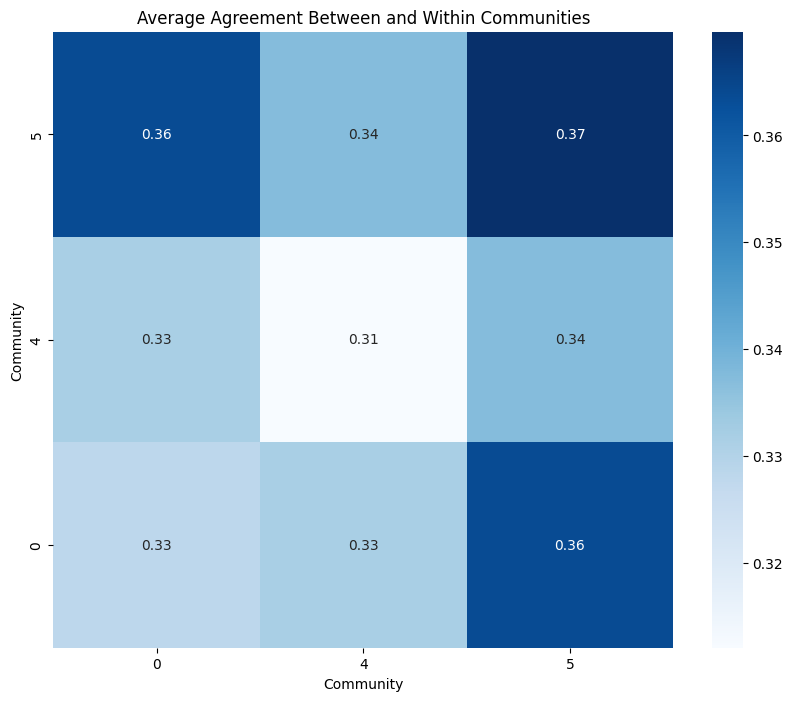

In [ ]:
calculate_and_plot_krippendorffs_alpha(communities_md_spectral, md_pivot_table, included_communities= [0, 4, 5], output_file='krippendorffs_alpha_md_spectral.png')

*Note that 3 clusters were tried for Spectral but that ended up with majority in one cluster.*

### Offensiveness Popquorn full dataset

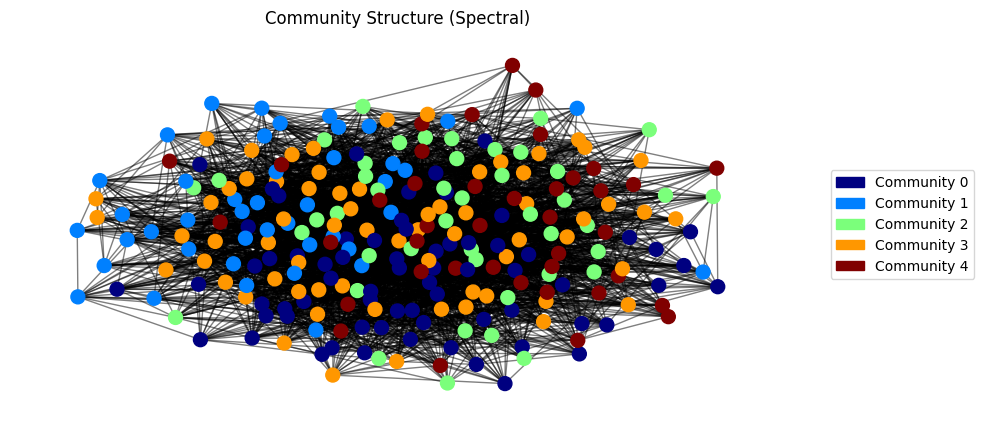

Community 3: [0, 62, 65, 138, 141, 148, 156, 168, 172, 239, 251, 43, 218, 74, 150, 198, 216, 28, 134, 221, 5, 31, 67, 115, 181, 214, 231, 259, 6, 46, 143, 151, 199, 234, 58, 87, 122, 113, 249, 159, 202, 101, 102, 256, 13, 71, 103, 164, 195, 196, 197, 50, 16, 86, 133, 179, 17, 18, 84, 44, 54, 22, 24, 55, 212, 110, 185]
Community 2: [34, 63, 112, 175, 193, 245, 1, 36, 236, 253, 82, 98, 38, 162, 163, 217, 70, 118, 177, 192, 224, 95, 53, 76, 92, 120, 136, 235, 123, 131, 241, 147, 225, 201, 157, 21, 68, 85, 88, 178, 25, 222, 206, 213]
Community 4: [35, 94, 219, 244, 56, 73, 121, 187, 3, 104, 247, 243, 39, 132, 161, 173, 205, 77, 107, 146, 9, 60, 119, 128, 153, 171, 12, 89, 169, 261, 99, 189, 238, 61, 137, 142, 250, 26, 211, 227]
Community 1: [81, 182, 69, 154, 167, 180, 188, 233, 37, 226, 49, 83, 64, 139, 140, 79, 129, 32, 96, 191, 252, 48, 93, 100, 190, 14, 130, 144, 246, 15, 145, 33, 166, 257, 23, 232, 229, 27, 242, 208, 210, 105, 42]
Community 0: [124, 125, 149, 209, 215, 223, 255, 114, 

In [ ]:
# Detect communities using spectral clustering
partition_op_spectral = detect_communities_spectral(G_op, 5, 'spectral_communities_op.png')

communities_op_spectral = print_communities_spectral(partition_op_spectral)

modularity_op_spectral = compute_modularity_spectral(G_op, partition_op_spectral)
print(f"Modularity (Spectral): {modularity_op_spectral}")

conductances = compute_conductance(G_op, partition_op_spectral)
average_conductance_op_spectral = sum(conductances.values()) / len(conductances)
print(f"Average Conductance (Spectral): {average_conductance_op_spectral}")

Average Annotators per Group: 52.40
Standard Deviation of Annotators per Group: 12.40


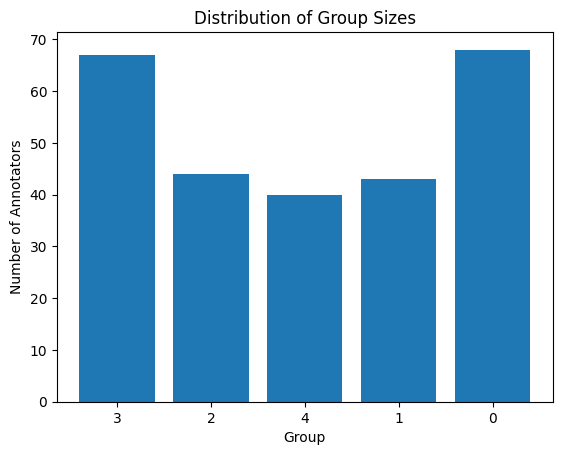

In [ ]:
calculate_metrics(communities_op_spectral)

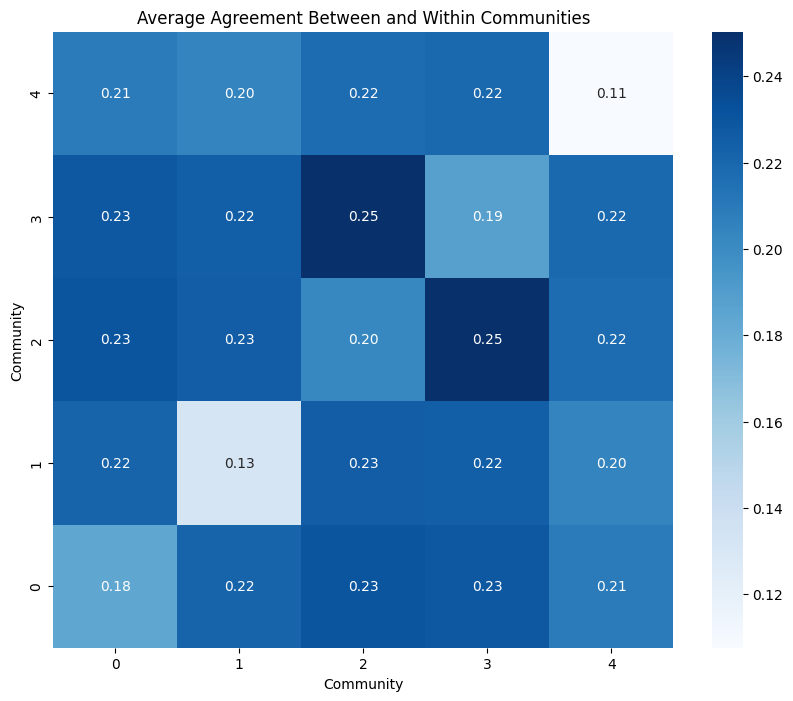

In [ ]:
calculate_and_plot_krippendorffs_alpha(communities_op_spectral, op_pivot_table, included_communities= [0, 1, 2, 3, 4], output_file='krippendorffs_alpha_op_spectral.png')

# Metrics for Clustering

- Modularity: Quantifies the strength of division of a network into communities. High modularity values (close to 1) indicate strong community structures.

- Conductance is a measure that evaluates the compactness of the communities and how well-separated they are from each other in a graph. Low conductance values indicate that the community is well-defined with many internal connections and few connections to nodes outside the community.

For efficient model training, looking for high modularity and low conductance and balanced communities.

In [ ]:
data = {
    'Dataset': ['MD dataset', 'OP dataset'],

    'Modularity (Louvain)': [modularity_md_louvain, modularity_op_louvain],
    'Conductance (Louvain)': [average_conductance_md_louvain, average_conductance_op_louvain],

    'Modularity (Leiden)': [modularity_md_leiden, modularity_op_leiden],
    'Conductance (Leiden)': [average_conductance_md_leiden, average_conductance_op_leiden],

    'Modularity (Spectral)': [modularity_md_spectral, modularity_op_spectral],
    'Conductance (Spectral)': [average_conductance_md_spectral, average_conductance_op_spectral],
}

df = pd.DataFrame(data)
df

Dataset  Modularity (Louvain)  Conductance (Louvain)  \
0  MD dataset              0.516594               0.315156   
1  OP dataset              0.157095               0.763675   

   Modularity (Leiden)  Conductance (Leiden)  Modularity (Spectral)  \
0             0.545447              0.215544               0.410004   
1             0.161086              0.715918               0.128108   

   Conductance (Spectral)  
0                0.130196  
1                0.669831

- Choosing MD-Agreement dataset with communities split using Leiden algorithm for model training. Chose the Leiden algorithm over the Spectral algorithm because Leiden provides higher modularity, indicating more robust community structure. While the Spectral algorithm has higher conductance, suggesting better connectedness between communities, also wanted a more equal split of communities for model training.

- The OP dataset, given its poor community definition and high intercommunity connections, is likely to result in models that are less accurate and generalised therefore not using for model training.

In [ ]:
def analyse_community_structure(G, communities):
    community_structure = {}
    for community, users in communities.items():
        subgraph = G.subgraph(users)
        community_structure[community] = {
            "nodes": len(subgraph.nodes),
            "edges": len(subgraph.edges),
            "average_degree": sum(dict(subgraph.degree()).values()) / len(subgraph.nodes) if subgraph.nodes else 0,
        }
    return community_structure

In [ ]:
community_structure = analyse_community_structure(G_md, communities_md_spectral)
community_structure

{4: {'nodes': 331, 'edges': 1104, 'average_degree': 6.670694864048339},
 5: {'nodes': 117, 'edges': 205, 'average_degree': 3.5042735042735043},
 0: {'nodes': 151, 'edges': 399, 'average_degree': 5.28476821192053},
 2: {'nodes': 2, 'edges': 1, 'average_degree': 1.0},
 3: {'nodes': 3, 'edges': 2, 'average_degree': 1.3333333333333333},
 1: {'nodes': 3, 'edges': 3, 'average_degree': 2.0}}

## Communities demographic breakdown

The distribution of gender and race attributes was assessed using the Leiden algorithm on the G_op graph.

In [ ]:
def count_attribute_in_communities(G, communities, attribute):

    attribute_counts = {}
    for community, nodes in communities.items():
        # Initialize counters for each attribute value
        counts = {}
        for node in nodes:
            attr_value = G.nodes[node].get(attribute, None)
            if attr_value:
                counts[attr_value] = counts.get(attr_value, 0) + 1
        attribute_counts[community] = counts
    return attribute_counts

attribute_counts_gender = count_attribute_in_communities(G_op, communities_op_leiden, 'gender')
attribute_counts_race = count_attribute_in_communities(G_op, communities_op_leiden, 'race')

print("Gender Counts in Communities:")
print(attribute_counts_gender)

print("Race Counts in Communities:")
print(attribute_counts_race)


Gender Counts in Communities:
{6: {'Man': 10, 'Woman': 10}, 3: {'Woman': 22, 'Man': 18}, 0: {'Woman': 25, 'Man': 22, 'Non-binary': 3}, 2: {'Woman': 20, 'Man': 19, 'Non-binary': 2}, 1: {'Man': 24, 'Woman': 20, 'Non-binary': 1}, 7: {'Man': 10, 'Woman': 8, 'Non-binary': 1}, 5: {'Woman': 17, 'Man': 6}, 4: {'Man': 15, 'Woman': 9}}
Race Counts in Communities:
{6: {'White': 18, 'Black or African American': 1, 'Native American': 1}, 3: {'Asian': 5, 'White': 28, 'Black or African American': 7}, 0: {'Black or African American': 5, 'White': 37, 'Asian': 3, 'Native American': 3, 'Hispanic or Latino': 1, 'Arab American': 1}, 2: {'White': 33, 'Black or African American': 2, 'Asian': 5, 'Hispanic or Latino': 1}, 1: {'White': 29, 'Black or African American': 10, 'Hispanic or Latino': 3, 'Asian': 2, 'Native American': 1}, 7: {'White': 14, 'Black or African American': 4, 'Asian': 1}, 5: {'White': 20, 'Black or African American': 3}, 4: {'White': 18, 'Black or African American': 2, 'Native American': 1, 

The distribution of race isn't balanced due to high presence of White ethnicities in each community due to unbalanced nature of ethnicities of annotators therefore not looking into it further. Gender can be assessed with the exception of non-binary.

Conduct a chi-square test to assess the statistical significance of the observed distributions in comparison to the overall distribution of the gender attribute in the graph.

Yates' correction is a statistical correction applied to the Chi-square test of independence when dealing with 2x2 contingency tables, especially when the sample sizes are small.

In [ ]:
def analyse_demographic_composition(G, communities, attribute, exclude=None):
    if exclude is None:
        exclude = []

    demographic_composition = {}

    # Overall demographic distribution in the graph
    overall_composition = {}

    for node in G.nodes():
        demographic = G.nodes[node].get(attribute, None)
        if demographic and demographic not in exclude:
            overall_composition[demographic] = overall_composition.get(demographic, 0) + 1

    overall_total = sum(overall_composition.values())
    overall_composition = {key: value / overall_total for key, value in overall_composition.items()}

    for community, nodes in communities.items():
        # Initialise counters for each demographic attribute value
        composition = {}

        # Iterate through nodes in the community
        for node in nodes:
            demographic = G.nodes[node].get(attribute, None)
            if demographic and demographic not in exclude:
                composition[demographic] = composition.get(demographic, 0) + 1

        # Calculate proportions
        total_nodes = sum(composition.values())
        composition = {demographic: count / total_nodes for demographic, count in composition.items()}

        demographic_composition[community] = composition

        # Visualisation
        plt.figure(figsize=(6,6))
        plt.title(f'Community {community}')
        plt.bar(composition.keys(), composition.values())
        plt.show()

        # Chi-Square Test
        observed = [composition.get(demographic, 0) * total_nodes for demographic in overall_composition.keys()]
        expected = [overall_composition[demographic] * total_nodes for demographic in overall_composition.keys()]

        # If any expected frequency is below 5, use the Yates' correction
        if min(expected) < 5:
          # ddof=1 applies Yates’ correction
            chi2, p = stats.chisquare(f_obs=observed, f_exp=expected, ddof=1)
            print(f"Chi-Square Value (Yates' correction): {chi2}")
            print(f"P-Value: {p}")
        else:
            chi2, p = stats.chisquare(f_obs=observed, f_exp=expected)
            print(f"Chi-Square Value: {chi2}")
            print(f"P-Value: {p}")

    return demographic_composition

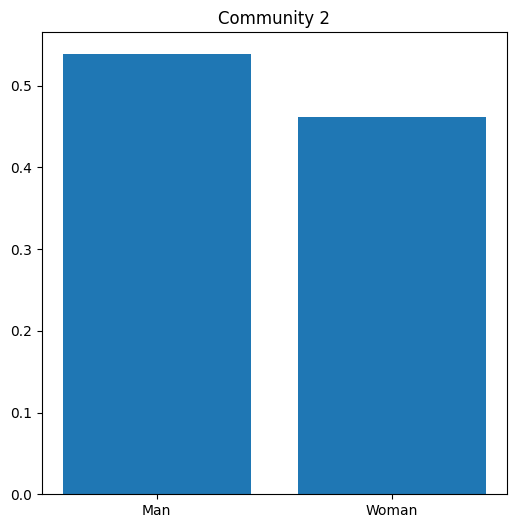

Chi-Square Value: 0.4251842100278439
P-Value: 0.5143614942141854


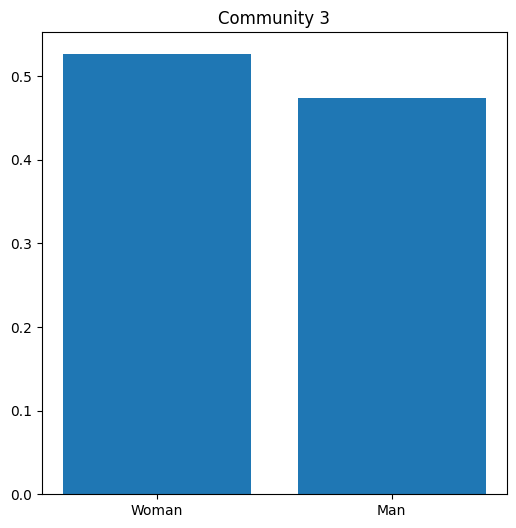

Chi-Square Value: 0.02411254681890642
P-Value: 0.8765988853542827


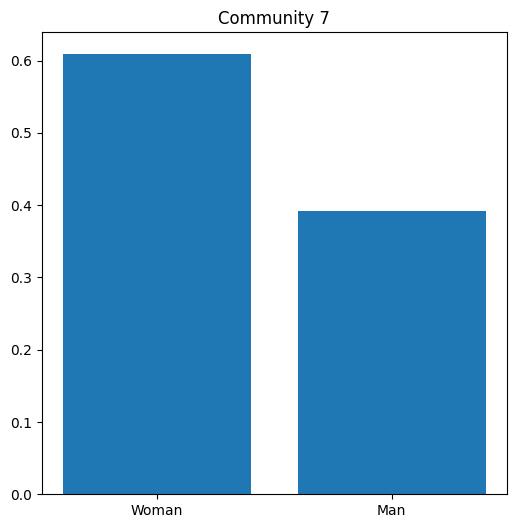

Chi-Square Value: 0.8304042696701394
P-Value: 0.3621556562699697


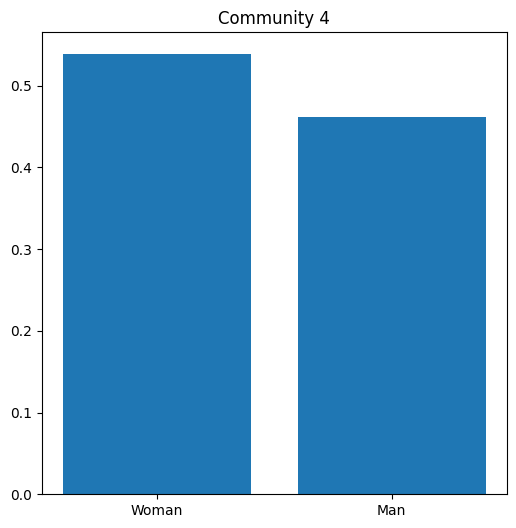

Chi-Square Value: 0.06368268520447794
P-Value: 0.800767232036333


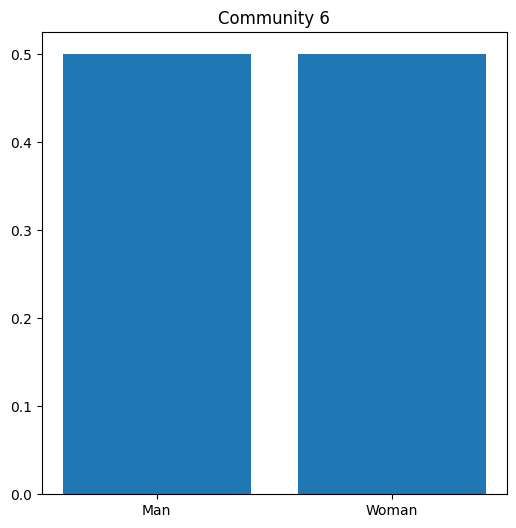

Chi-Square Value: 0.01809899039645405
P-Value: 0.8929815226769015


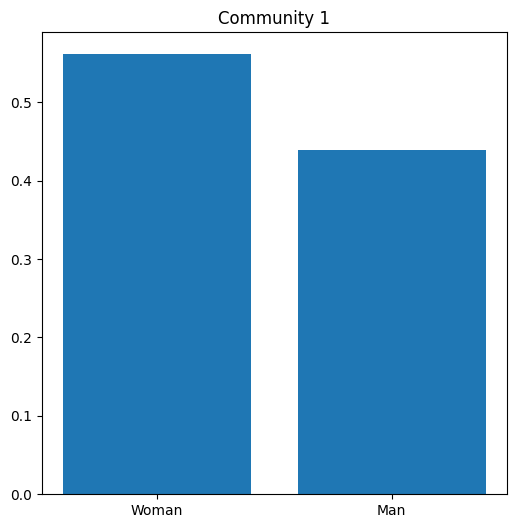

Chi-Square Value: 0.3664182197103929
P-Value: 0.5449631480326637


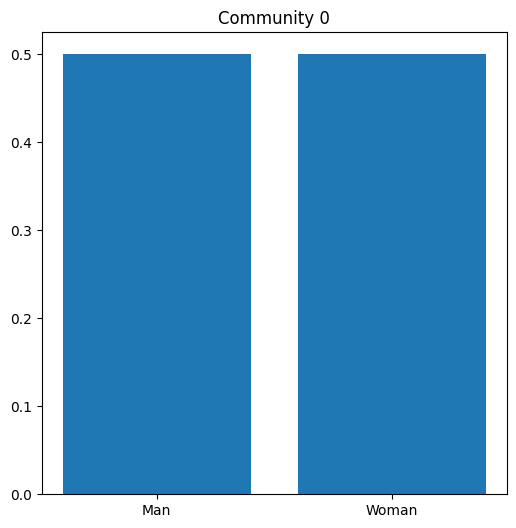

Chi-Square Value: 0.030164983994090115
P-Value: 0.8621164096820021


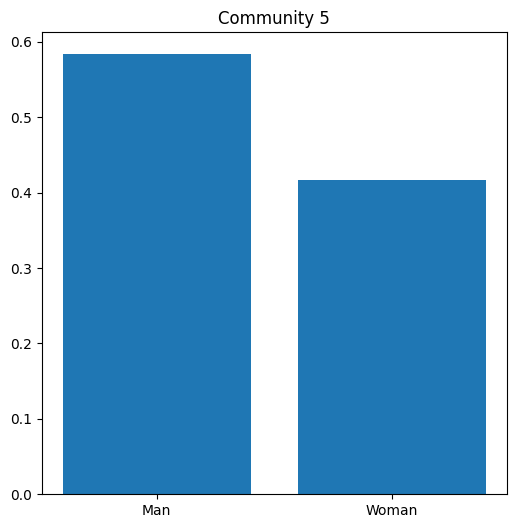

Chi-Square Value: 0.9050418616104406
P-Value: 0.3414333904269117


In [ ]:
demographic_composition_gender = analyse_demographic_composition(G_op, communities_op_leiden, attribute='gender', exclude=['Non-binary'])

The chi-square test results shows that for all the tested communities, there is a high p-value (all above 0.05) therefore fail to reject the null hypothesis. The null hypothesis for a chi-square goodness of fit test is that the observed frequency distribution does not significantly differ from the expected frequency distribution.

# Step 5: Save groups as datasets

Save individual ratings split by communtities

In [ ]:
def assign_community_labels(data, communities):
    data['community'] = None
    for community, users in communities.items():
        data.loc[data['user_id'].isin(users), 'community'] = community
    return data

def split_data_by_community(data, communities, selected_communities=None):
    data = assign_community_labels(data, communities)
    if selected_communities:
        community_dfs = {community: data[data['community'] == community] for community in selected_communities}
    else:
        community_dfs = {community: data[data['community'] == community] for community in communities.keys()}

    return community_dfs

In [ ]:
selected_communities = [0, 1, 2, 3]

communities_md = split_data_by_community(md_agreement, communities_md_leiden, selected_communities)

for community, df in communities_md.items():
    df.to_csv(f"community_{community}_data_final_md_leiden.csv", index=False)

combined_selected_data = pd.concat(communities_md.values(), axis=0)
combined_selected_data.to_csv("combined_communities_data_final_md_leiden.csv", index=False)

Save community majority ratings split by communtities

In [ ]:
def compute_majority_offensiveness(df):
    majority_vote_df = df.groupby('instance_id').agg({
        'offensiveness': lambda x: x.mode().iloc[0] if not x.mode().empty else None,
        'cleaned_text': 'first',
        'cleaned_domain': 'first'
    }).reset_index()

    return majority_vote_df


def create_and_save_datasets(community_dfs, combined_data):
    for community, df in community_dfs.items():
        majority_df = compute_majority_offensiveness(df)
        majority_df.to_csv(f"majority_community_{community}_data_final_md_leiden.csv", index=False)

    majority_combined_df = compute_majority_offensiveness(combined_data)
    majority_combined_df.to_csv("majority_combined_communities_data_final_md_leiden.csv", index=False)

In [ ]:
create_and_save_datasets(communities_md, combined_selected_data)